<a href="https://colab.research.google.com/github/MartsenkoVS/ISIC_2024/blob/main/ISIC_2024_all_exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!pip -q install timm

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import gc
from tqdm import tqdm
from collections import defaultdict

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

import gdown
import shutil
import os
import json

# Натройка одинакового разбиения
seed_value = 42

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Просмотр датасета:

In [ ]:
# Функция для загрузки и разархивации файлов
def download_and_extract(url, output_archive, extract_to):
    # Скачивание архива
    gdown.download(url, output_archive, quiet=False)

    # Разархивация скачанного файла
    shutil.unpack_archive(output_archive, extract_to)

    # Удаляем архив
    os.remove(output_archive)

In [ ]:
# Загружаем датасет
project_dir = 'ISIC_2024'
os.makedirs(project_dir, exist_ok=True)
url = 'https://drive.google.com/uc?id=1GfUQVahq13JnZ1iMVKKU2B_dsRit1hAL'
output_archive = 'dataset.zip'
download_and_extract(url, output_archive, project_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1GfUQVahq13JnZ1iMVKKU2B_dsRit1hAL
From (redirected): https://drive.google.com/uc?id=1GfUQVahq13JnZ1iMVKKU2B_dsRit1hAL&confirm=t&uuid=a648a71b-adcc-4a5b-81bf-b55e33017195
To: /content/dataset.zip
100%|██████████| 988M/988M [00:15<00:00, 64.9MB/s]


In [ ]:
# Открытие файла HDF5
data_path = '/content/ISIC_2024/Dataset/train-image.hdf5'
metadata_path = '/content/ISIC_2024/Dataset/train-metadata.csv'

# Чтение метаданных
metadata = pd.read_csv(metadata_path)

In [ ]:
metadata

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


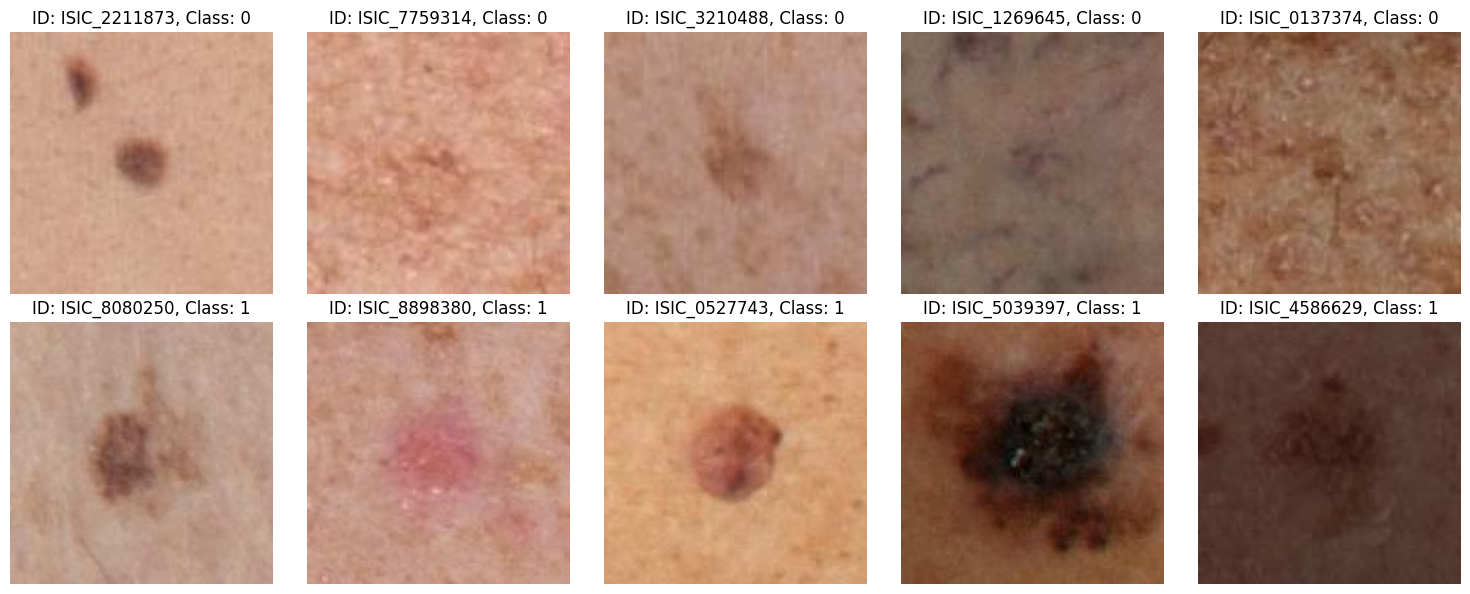


Распределение классов:
target
0    400666
1       393
Name: count, dtype: int64


In [ ]:
# Группировка индексов по классам
grouped = metadata.groupby('target')

# Выбор по 5 примеров каждого класса
selected_indices = {label: group.sample(n=5, random_state=None).index.tolist() for label, group in grouped}

# Открытие файла данных HDF5
with h5py.File(data_path, 'r') as h5_file:
    # Подготовка к отображению изображений
    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=5, figsize=(15, len(selected_indices)*3))
    for i, (label, indices) in enumerate(selected_indices.items()):
        for j, idx in enumerate(indices):
            img_name = metadata.loc[idx, 'isic_id']  # Название изображения должно быть в metadata
            image = np.array(h5_file[img_name])  # Загрузка изображения
            image = Image.open(io.BytesIO(image))  # Конвертация в PIL Image
            axes[i, j].imshow(image)
            axes[i, j].set_title(f'ID: {img_name}, Class: {label}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

print("\nРаспределение классов:")
print(metadata['target'].value_counts())

# Сервисные классы и функции

In [ ]:
# Класс для создания датасета из h5py файла
class HDF5Dataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        if img_name in self.data:
            # Получение байтового потока изображения
            image_data = self.data[img_name][()]
            # Создание изображения из байтов
            image = Image.open(io.BytesIO(image_data))
            image = np.array(image)  # Преобразование изображения PIL в NumPy массив

            if self.transform:
                # Применение трансформации с использованием именованных аргументов
                image = self.transform(image=image)['image']

            label = int(self.metadata.iloc[idx]['target'])
            return image, label

In [ ]:
# Функция для расчета метрики на конкурсе
"""
2024 ISIC Challenge primary prize scoring metric

Given a list of binary labels, an associated list of prediction
scores ranging from [0,1], this function produces, as a single value,
the partial area under the receiver operating characteristic (pAUC)
above a given true positive rate (TPR).
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

(c) 2024 Nicholas R Kurtansky, MSKCC
"""

def score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float=0.80) -> float:
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return(partial_auc)

In [ ]:
# Функции для расчета и визуализации confusion matrix
def calculate_confusion_matrix(y_true, y_proba, min_tpr=0.8):
    """
    Вычисляет оптимальный порог и матрицу ошибок на основе предсказаний и истинных меток.

    Параметры:
        y_true (numpy.ndarray): Истинные метки.
        y_proba (numpy.ndarray): Предсказанные вероятности.
        min_tpr (float): Минимальное значение TPR для выбора оптимального порога.

    Возвращает:
        optimal_threshold (float): Оптимальный порог для классификации.
        cm (numpy.ndarray): Матрица ошибок.
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    youden_index = tpr - fpr

    idx = np.where(tpr >= min_tpr)[0]

    if len(idx) == 0:
        print(f"Не удалось достичь TPR ≥ {min_tpr*100:.0f}%")
        # Выбираем порог с максимальным TPR
        optimal_idx = np.argmax(tpr)
        optimal_threshold = thresholds[optimal_idx]
    else:
        youden_subset = youden_index[idx]
        optimal_idx = idx[np.argmax(youden_subset)]
        optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_proba >= optimal_threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    # Выводим результаты
    print(f"Оптимальный порог: {optimal_threshold:.4f}")
    print(f"TPR: {tpr[optimal_idx]:.4f}")
    print(f"FPR: {fpr[optimal_idx]:.4f}")
    print(f"Статистика Юдена: {youden_index[optimal_idx]:.4f}")
    print("Матрица ошибок:")
    print(cm)
    print("-" * 30)

    # Визуализируем ROC-кривую и точку выбранного порога
    plt.figure()
    plt.plot(fpr, tpr, label='ROC-кривая')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Оптимальный порог')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

    return optimal_threshold, cm


# Функция суммирует матрицы и визуалирует общую confusion matrix
def total_cm_visualize(confusion_matrices):
    total_cm = sum(confusion_matrices)

    # Отображаем матрицу ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=total_cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar=False)
    plt.title('Общая матрица ошибок (Абсолютные значения)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    # Вычисляем матрицу ошибок в процентах
    cm_percent = (total_cm.astype('float') / total_cm.sum(axis=1)[:, np.newaxis]) * 100

    # Отображаем матрицу ошибок в процентах
    disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
    # Отображаем матрицу ошибок в процентах с добавлением знака процента
    disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
    fig, ax = plt.subplots()
    disp_percent.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    plt.title('Общая матрица ошибок (Проценты по строкам)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

    # Добавляем знак процента к текстовым аннотациям
    # Получаем список текстовых аннотаций на графике
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            # Значение с двумя знаками после запятой и знак процента
            value = cm_percent[i, j]
            text = ax.texts[i * cm_percent.shape[1] + j]
            text.set_text(f"{value:.2f}%")

    plt.show()

In [ ]:
# Функция для обучения модели
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                scheduler,
                num_epochs,
                device,
                exp_num,
                model_name,
                project_dir='.',
                fold=None,
                checkpoint_save=False,
                min_tpr=0.8,
                ):

    history = defaultdict(list)
    best_Pauc = -float('inf')
    best_model_dir = f'{project_dir}/best_models/exp{exp_num}_{model_name}'
    os.makedirs(best_model_dir, exist_ok=True)

    if fold:
        best_model_path = f'{best_model_dir}/exp{exp_num}_fold{fold}.pth'
    else:
        best_model_path = f'{best_model_dir}/exp{exp_num}_{model_name}.pth'


    # Цикл по эпохам обучения
    for epoch in range(num_epochs):  # Пример количества эпох
        model.train()  # Перевод модели в режим обучения
        running_loss = 0.0

        # Обработка батчей данных
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images  = images.to(device, non_blocking=True)  # Перемещение данных на GPU, если доступно
            labels = labels.float().view(-1, 1).to(device, non_blocking=True)

            optimizer.zero_grad()  # Очистка градиентов
            outputs = model(images)  # Вычисление предсказаний модели
            loss = criterion(outputs, labels)  # Расчет потерь
            loss.backward()  # Обратное распространение ошибки для обновления весов
            optimizer.step()  # Обновление весов
            running_loss += loss.item() * images.size(0)  # Накопление потерь для вывода среднего

        train_loss = running_loss / len(train_loader.dataset)
        history['Train Loss'].append(train_loss)

        # Валидация модели
        model.eval()  # Перевод модели в режим оценки
        val_loss = 0.0
        solution = []
        submission = []
        with torch.no_grad():  # Отключение вычисления градиентов
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                images  = images.to(device, non_blocking=True)  # Перемещение данных на GPU, если доступно
                labels = labels.float().view(-1, 1).to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                probabilities = outputs.cpu().numpy()
                submission.extend(probabilities[:, 0])
                solution.extend(labels.cpu().numpy()[:, 0])

        val_loss = val_loss / len(val_loader.dataset)
        history['Valid Loss'].append(val_loss)

        # Расчет и вывод метрик обучения и валидации
        solution_df = pd.DataFrame(solution, columns=['target'])
        submission_df = pd.DataFrame(submission, columns=['score'])
        pAUC = score(solution_df, submission_df)
        history['Validation pAUC'].append(pAUC)
        lr = optimizer.param_groups[0]['lr']
        history['Learning Rate'].append(lr)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, pAUC: {pAUC:.4f}, lr: {lr}")

        # Обновление скорости обучения после завершения каждой эпохи
        scheduler.step()

        # Сохранение модели на лучшей эпохе
        if pAUC > best_Pauc:
            best_Pauc = pAUC

            if checkpoint_save:
                # Сохраняем чекпоинт с полным состоянием модели, с возможностью продолжить обучение
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                }, best_model_path)
            else:
                # Сохраняем только веса
                torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model with pAUC: {pAUC}")

            # Сохраняем предсказания и метки на валидации для лучшей модели
            best_val_solution = solution.copy()
            best_val_submission = submission.copy()

        # Принудительная сборка мусора после каждой эпохи
        gc.collect()

    # После завершения обучения вычисляем оптимальный порог и матрицу ошибок
    print("Вычисление оптимального порога и матрицы ошибок на валидационной выборке...")

    # Преобразуем списки в numpy массивы
    y_true = np.array(best_val_solution)
    y_proba = np.array(best_val_submission)

    # Вызываем функцию для расчёта оптимального порога и матрицы ошибок
    optimal_threshold, cm = calculate_confusion_matrix(y_true, y_proba, min_tpr)

    # График обучения
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['Train Loss'], label='Train Loss')
    plt.plot(history['Valid Loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(num_epochs))

    plt.subplot(1, 2, 2)
    plt.plot(history['Validation pAUC'], label='Validation pAUC')
    plt.title('pAUC During Training')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('pAUC')
    plt.xticks(range(num_epochs))

    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history['Learning Rate'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.xticks(range(num_epochs))

    plt.show()

    return history, optimal_threshold, cm

In [ ]:
# Функция для вывода результатов val_pAUC по всем фолдам
def crossvalidation_results(history_list):
    best_pAUCs = []

    for history in history_list:
        val_pAUC = history['Validation pAUC']
        best_pAUCs.append(val_pAUC)

    cv_pAUC = round(np.mean(best_pAUCs), 4)
    print(f'Показатели val_pAUC по всем фолдам: {best_pAUCs}')
    print(f'Средний показатель по всем фолдам: {cv_pAUC}')

In [ ]:
# Создадим переменную, в которой будет храниться тип устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Оценка обученных моделей  

В конкурсе ключевая метрика pAUC при tpr>=0.8, ориентироваться буду на нее.  При отправке заявки расчитывается результат на 28% тестовых данных конкурса pAUC (далее Public Score pAUC).  
Дополнительно, для наглядности посчитаю Confusion Matrix.  
Для этого посчитаю оптимальный порог вероятностей и confusion matrix для модели по каждому фолду. Затем, объединю результаты в итоговую confusion matrix и посчитаю общие TPR, FPR по всему датасету.  
**Расчет оптимального порога вероятностей:** Исходя из условия конкурса, нас интересует порог при TPR>= 0.8, далее нахожу максимальный Индекс Юдена (TPR - FPR).

# Эксперимент 1:
Наблюдается огромный дисбаланс классов. Но все равно, попробую обучить на всех данных. Для разбивки на выборки буду использовать StratifiedGroupKFold с группировкой по полю patient_id.
Так как датасет большой, сначала проверю результаты обучения на 0 фолде и 10 эпохах.

Параметры для обучения:  

| Параметр                | Значение                      |
|-------------------------|-------------------------------|
| Количество folds        | 5                             |
| Сколько folds обучаем   | 1                             |
| Предобученная модель    | 'efficientnet_b0'             |
| Оптимизатор             | Adam(lr=1e-4)                 |
| Планировщик скорости    | CosineAnnealingLR, T_max=10   |
| Количество эпох         | 10                            |
| Размер батча (train)    | 32                            |
| Размер батча (val)      | 64                            |
| Функция потерь          | BCELoss                       |


In [ ]:
# Трансформация для тренировочного набора, с аугментацией
train_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.OneOf([A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
             A.RandomBrightnessContrast()
             ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])

# Трансформация для валидационного набора, без аугментации
val_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0),
    ToTensorV2(),
])

In [ ]:
# Инициализация StratifiedGroupKFold для разбиения датасета на folds
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [ ]:
# Класс для создания модели
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(CustomModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(in_features, 1)  # Заменяем классификатор

    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

Training fold 1


Epoch 1 Validation: 100%|██████████| 1112/1112 [01:23<00:00, 13.36it/s]


Epoch 1, Train Loss: 0.0085, Val Loss: 0.0071, pAUC: 0.1435
Saved new best model with pAUC: 0.14347136297754992 on fold 0


Epoch 2 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.19it/s]


Epoch 2, Train Loss: 0.0060, Val Loss: 0.0072, pAUC: 0.1218


Epoch 3 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.15it/s]


Epoch 3, Train Loss: 0.0057, Val Loss: 0.0079, pAUC: 0.1117


Epoch 4 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.21it/s]


Epoch 4, Train Loss: 0.0054, Val Loss: 0.0068, pAUC: 0.1372


Epoch 5 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.11it/s]


Epoch 5, Train Loss: 0.0049, Val Loss: 0.0069, pAUC: 0.1453
Saved new best model with pAUC: 0.14528995683356655 on fold 0


Epoch 6 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.17it/s]


Epoch 6, Train Loss: 0.0041, Val Loss: 0.0077, pAUC: 0.1122


Epoch 7 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.12it/s]


Epoch 7, Train Loss: 0.0033, Val Loss: 0.0086, pAUC: 0.1022


Epoch 8 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.16it/s]


Epoch 8, Train Loss: 0.0025, Val Loss: 0.0091, pAUC: 0.1101


Epoch 9 Validation: 100%|██████████| 1112/1112 [01:24<00:00, 13.20it/s]


Epoch 9, Train Loss: 0.0017, Val Loss: 0.0102, pAUC: 0.1012


Epoch 10 Validation: 100%|██████████| 1112/1112 [01:25<00:00, 13.04it/s]


Epoch 10, Train Loss: 0.0015, Val Loss: 0.0104, pAUC: 0.0918


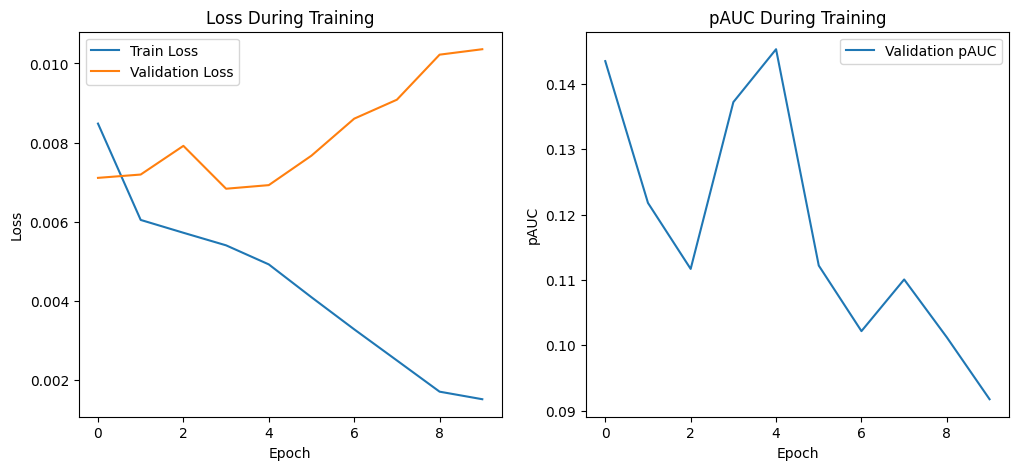

In [ ]:
exp_num = 1
model_name = 'efficientnet_b0'
num_epochs = 10
criterion = nn.BCELoss()
fold_counter = 0
history_list = []
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (train_idx, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Training fold {fold+1}")

    model = CustomModel(model_name)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    train_data = HDF5Dataset(data_path, metadata.iloc[train_idx], transform=train_transform)
    val_data = HDF5Dataset(data_path, metadata.iloc[val_idx], transform=val_transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    history, optimal_threshold, cm = train_model(model,
                                                 train_loader,
                                                 val_loader,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs,
                                                 device,
                                                 exp_num,
                                                 model_name,
                                                 project_dir,
                                                 fold,
                                                 checkpoint_save=False,
                                                 min_tpr=0.8,
                                                 )
    # Записываем историю обучения по фолду
    history_list.append(history)
    optimal_thresholds.append(optimal_threshold)
    confusion_matrices.append(cm)

    fold_counter += 1
    # Остановка после первого фолда
    if fold_counter == 1:
        break

**Результат обучения:**
После 5 эпохи модель ушла в переобучение. Сохранил ее на 5 эпохе:  
pAUC: 0.1453  
Public Score pAUC: 0.1353

**Выводы:**
Модель переобучается на полном датасете, так как присутствует огромный дисбаланс классов (1000:1).

**План дальнейшей работы:**
1. Применить методы ресемплинга для устранения дисбаланса.
2. Провести эксперименты с гиперпараметрами (добавить регуляризацию для устранения переобучения).
3. Провести эксперименты с архитектурой нейронной сети (добавить слой Gem Pooling).
4. Провести эксперименты с аугментацией.
5. Обучить модель ResNet18.

# Эксперимент 2:  
Продолжил эксперименты на всем датасете, но результат не улучшался.
Эксперименты, которые не улучшили результаты:
1. Добавление регуляризации weight_decay = 1e-6, 1e-5, 1e-4
2. Изменение параметров аугментации
3. Изменение параметров learning_rate

Изменил в нормализации параметр max_pixel_value=255.0, остальные параметры вернул к 1 эксперименту, обучил на всех данных 5 folds, 5 эпох.

Параметры для обучения:  

| Параметр                | Значение                      |
|-------------------------|-------------------------------|
| Количество folds        | 5                             |
| Сколько folds обучаем   | 5                             |
| Предобученная модель    | 'efficientnet_b0'             |
| Оптимизатор             | Adam(lr=1e-4)                 |
| Планировщик скорости    | CosineAnnealingLR, T_max=5    |
| Количество эпох         | 5                             |
| Размер батча (train)    | 32                            |
| Размер батча (val)      | 64                            |
| Функция потерь          | BCELoss                       |


In [ ]:
# Трансформация для тренировочного набора, с аугментацией
train_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.OneOf([A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
             A.RandomBrightnessContrast()
             ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

# Трансформация для валидационного набора, без аугментации
val_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

In [ ]:
# Инициализация StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [ ]:
# Класс для создания модели EfficientNet
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(CustomEfficientNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(in_features, 1)  # Заменяем классификатор

    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
exp_num = 2
model_name = 'efficientnet_b0'
num_epochs = 5
criterion = nn.BCELoss()
history_list = []
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (train_idx, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Training fold {fold+1}")

    model = CustomEfficientNet(model_name)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_data = HDF5Dataset(data_path, metadata.iloc[train_idx], transform=train_transform)
    val_data = HDF5Dataset(data_path, metadata.iloc[val_idx], transform=val_transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4. pin_memory=True)

    history, optimal_threshold, cm = train_model(model,
                                                 train_loader,
                                                 val_loader,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs,
                                                 device,
                                                 exp_num,
                                                 model_name,
                                                 project_dir,
                                                 fold,
                                                 checkpoint_save=False,
                                                 min_tpr=0.8,
                                                 )
    # Записываем историю обучения по фолду
    history_list.append(history)
    optimal_thresholds.append(optimal_threshold)
    confusion_matrices.append(cm)

# Визуализируем общую матрицу ошибок
total_cm_visualize(confusion_matrices)

# Выводим результаты val_pAUC по всем фолдам
crossvalidation_results(history_list)

**Графики обучения:**  
Training fold 1:
![График 1 fold](https://drive.google.com/uc?export=view&id=1DP2vSMtHt6ONh6DMllD9sxWUNx-pvnSi)  
best model with pAUC: 0.1419827981754397 on fold 1 (epoch 3)


---


Training fold 2:  
![График 2 fold](https://drive.google.com/uc?export=view&id=183tgc_6rcBXi5iUkxLaPjzoezbqqD3tZ)  
best model with pAUC: 0.1388987965040524 on fold 2 (epoch 5)


---


Training fold 3:  
![График 3 fold](https://drive.google.com/uc?export=view&id=16dmVSFyuUbZIgE62I7kzXkcd22i_Ht_m)  
best model with pAUC: 0.16481729715795573 on fold 3 (epoch 5)


---


Training fold 4:  
![График 4 fold](https://drive.google.com/uc?export=view&id=1ZsNrv3qAMOgv3m7nCxBQMzetXlaVPisv)  
best model with pAUC: 0.13305538314401644 on fold 4 (epoch 2)  


---


Training fold 5:  
![График 5 fold](https://drive.google.com/uc?export=view&id=158j26Qo2SeuS0Zo7-Y1yF1n73AOyo1W3)  
best model with pAUC: 0.15957705096566457 on fold 5 (epoch 5)


---




In [ ]:
# Считаем показатели моделей по кроссвалидации
best_pAUCs = [0.142, 0.1389, 0.1648, 0.1331, 0.1596]
cv_pAUC = round(np.mean(best_pAUCs), 4)
print(f'CV: {cv_pAUC}')
print('LB: 0.13418')

CV: 0.1477
LB: 0.13418


## Confusion Matrix эксперимент 2
Этот раздел нужен только для демонстрации Confusion Matrix для ранее обученных моделей (в предудущих сеансах). Позже добавил этот функционал в функцию train_model, при новом запуске ячеек обучения моделей confusion matrix рассчитывается, и этот раздел не нужен.

In [ ]:
# Загружаем модели
url = 'https://drive.google.com/uc?id=1BDAqXw-XJhQ517G5ZA4k2wARyglKUFaz'
models_dir = os.path.join(project_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
output_archive = 'exp2_efficientnet_b0.zip'
download_and_extract(url, output_archive, models_dir)

Fold 1
Оптимальный порог: 0.0007
TPR: 0.8554
FPR: 0.1464
Статистика Юдена: 0.7090
Матрица ошибок:
[[60675 10406]
 [   12    71]]
------------------------------


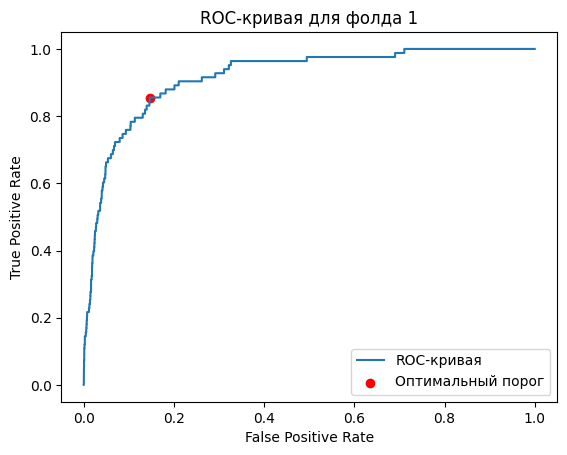

Fold 2
Оптимальный порог: 0.0003
TPR: 0.8077
FPR: 0.1438
Статистика Юдена: 0.6639
Матрица ошибок:
[[74674 12542]
 [   15    63]]
------------------------------


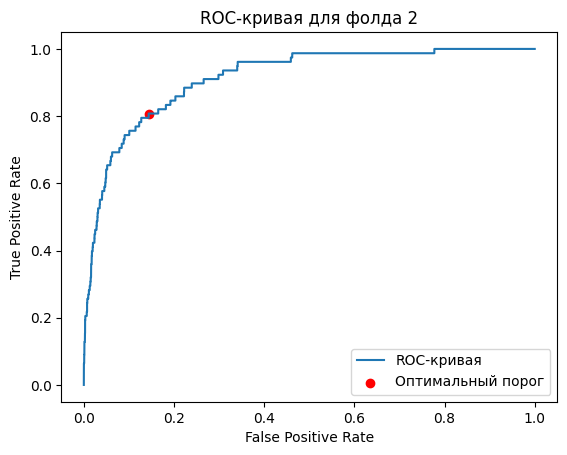

Fold 3
Оптимальный порог: 0.0006
TPR: 0.9000
FPR: 0.0909
Статистика Юдена: 0.8091
Матрица ошибок:
[[70534  7051]
 [    6    54]]
------------------------------


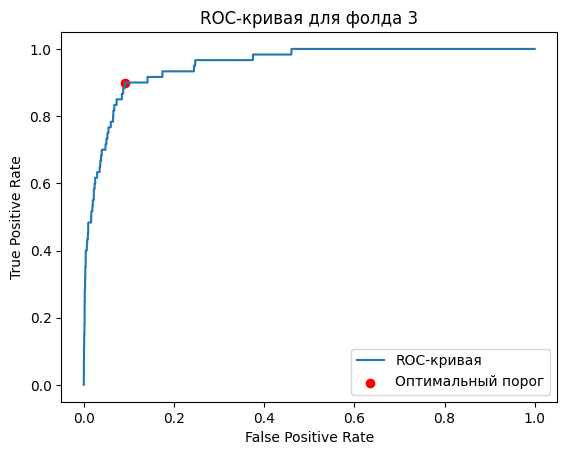

Fold 4
Оптимальный порог: 0.0004
TPR: 0.8764
FPR: 0.1651
Статистика Юдена: 0.7113
Матрица ошибок:
[[69520 13752]
 [   11    78]]
------------------------------


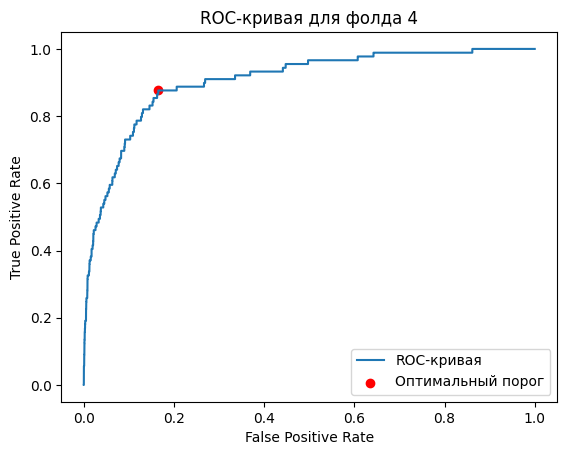

Fold 5
Оптимальный порог: 0.0011
TPR: 0.8434
FPR: 0.0742
Статистика Юдена: 0.7691
Матрица ошибок:
[[75461  6051]
 [   13    70]]
------------------------------


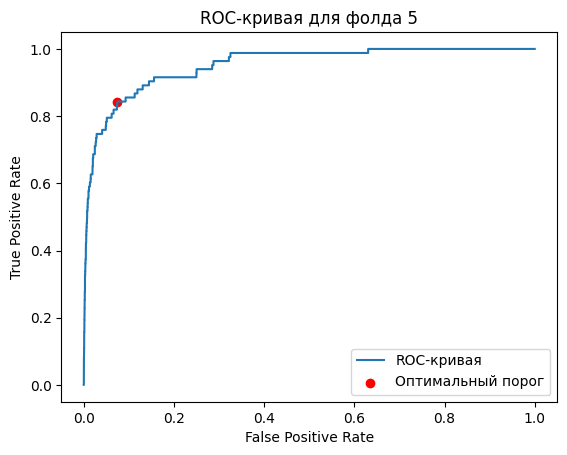

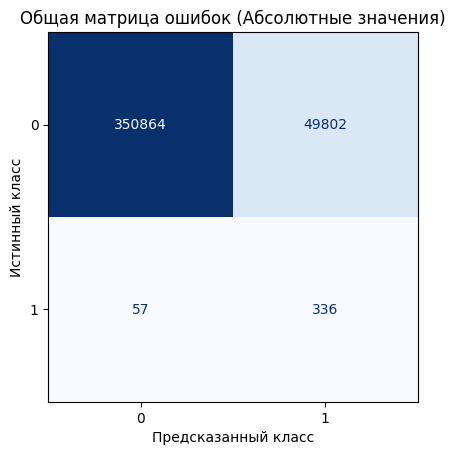

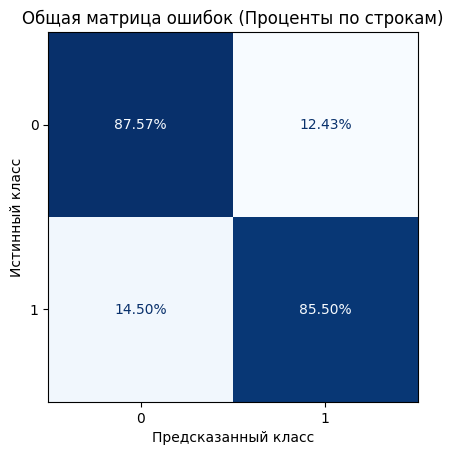

In [ ]:
# Списки для хранения confusion matrix и порогов вероятности каждого фолда
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (_, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Fold {fold+1}")

    model_weights = f'/content/ISIC_2024/models/exp2_EfficientNet_b0/exp2_fold{fold}.pth'
    model = CustomEfficientNet(pretrained=False)
    model.load_state_dict(torch.load(model_weights))
    model.to(device)
    model.eval()  # Устанавливаем режим оценки для модели

    # Достаем подмножество данных для текущего фолда
    val_metadata = metadata.iloc[val_idx].reset_index(drop=True)
    val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    # Списки для хранения истинных меток и предсказанных вероятностей
    y_true = []
    y_proba = []

    # Проходим по валидационному загрузчику и собираем предсказания и метки
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            # Получаем предсказания модели
            outputs = model(images).squeeze()
            probabilities = outputs.cpu().numpy()

            # Сохраняем предсказания и метки
            y_proba.extend(probabilities)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    # Вычисляем пороги и confusion matrix
    optimal_threshold, cm = calculate_confusion_matrix(y_true, y_proba, min_tpr=0.8)
    confusion_matrices.append(cm)
    optimal_thresholds.append(optimal_threshold)

# Сводим матрицы ошибок и визуализируем общую матрицу
total_cm_visualize(confusion_matrices)

## Итоги эксперимента
**Результат обучения:**  
СV pAUC: 0.1477  
Public Score pAUC: 0.13418

**Выводы:**
Результат на валидационных данных улучшился, но на тестовых данных получился чуть ниже, чем в 1 эксперименте, попробую эксперименты с undersampling для уменьшения дисбаланса датасета.

**План дальнейшей работы:**
1. Применить методы ресемплинга для устранения дисбаланса.
2. Провести эксперименты с гиперпараметрами (добавить регуляризацию для устранения переобучения).
3. Провести эксперименты с архитектурой нейронной сети (добавить слой Gem Pooling).
4. Провести эксперименты с аугментацией.
5. Обучить модель ResNet18.

# Эксперимент 3:
Обучение с применением undersampling (уменьшение изображений большего класса до соотношения 20:1). Сначала не приводило к улучшению результата.  
Внесенные изменения:
1. Добавил слой Gem Pooling
2. Поменял параметры аугментации.
2. Поменял параметры планировщика скорости обучения: scheduler = CosineAnnealingLR(optimizer, T_max=500) (скорость обучения постепенно уменьшается на небольшое значение)
3. Поставил регуляризацию weight_decay=1e-4, результаты стали лучше.   
Обучил на всех 5 фолдах по 20 эпох:


Параметры для обучения:  

| Параметр                | Значение                        |
|-------------------------|---------------------------------|
| Количество folds        | 5                               |
| Сколько folds обучаем   | 5                               |
| Предобученная модель    | 'efficientnet_b0'               |
| Оптимизатор             | Adam(lr=1e-4, weight_decay=1e-4)|
| Планировщик скорости    | CosineAnnealingLR, T_max=500    |
| Количество эпох         | 20                              |
| Размер батча (train)    | 32                              |
| Размер батча (val)      | 64                              |
| Функция потерь          | BCELoss                         |


In [ ]:
# Трансформация для тренировочного набора, с аугментацией
train_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(p=0.5),
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

# Трансформация для валидационного набора, без аугментации
val_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

In [ ]:
# Инициализация StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [ ]:
# Класс для создания слоя Gem Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
# Класс для создания модели EfficientNet с GeM pooling
class CustomEfficientNetGem(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(CustomEfficientNetGem, self).__init__()

        # Создаем базовую модель EfficientNet
        self.model = timm.create_model(model_name, pretrained=pretrained)

        # Убираем стандартный глобальный пулинг и классификатор
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()

        # Получаем количество входных фичей после свёрточной части
        in_features = self.model.num_features

        # Добавляем GeM pooling
        self.gem_pooling = GeM()

        # Добавляем свой классификатор
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # Прогоняем через основную часть модели (свёрточную)
        x = self.model.forward_features(x)

        # Применяем GeM pooling
        x = self.gem_pooling(x)

        # Выравниваем для подачи в классификатор
        x = x.view(x.size(0), -1)

        # Пропускаем через классификатор
        x = self.classifier(x)

        # Применяем сигмоиду для получения вероятности класса
        x = torch.sigmoid(x)
        return x

In [ ]:
# Обучение EfficientNet_b0 5 folds, downsampling 20:1
exp_num = 3
model_name = 'efficientnet_b0'
ratio = 20
num_epochs = 20
criterion = nn.BCELoss()
history_list = []
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (train_idx, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Training fold {fold+1}")

    model = CustomEfficientNetGem(model_name)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=500)

    # Достаем подмножество данных для текущего фолда
    train_metadata = metadata.iloc[train_idx]
    val_metadata = metadata.iloc[val_idx]

    # Выводим статистику до ресэмплинга
    print(f"Pre-undersampling: Train size = {len(train_metadata)}, Positive class = {sum(train_metadata['target']==1)}, Negative class = {sum(train_metadata['target']==0)}")
    print(f"Validation size = {len(val_metadata)}, Positive class = {sum(val_metadata['target']==1)}, Negative class = {sum(val_metadata['target']==0)}")

    # Применяем undersampling
    majority_class = train_metadata[train_metadata['target'] == 0]
    minority_class = train_metadata[train_metadata['target'] == 1]

    # Ресэмплинг большего класса до размера меньшего класса
    majority_downsampled = resample(majority_class,
                                    replace=False,  # без возвращения
                                    n_samples=len(minority_class)*ratio,  # соотношение 20:1
                                    random_state=seed_value)  # для воспроизводимости

    # Объединяем сбалансированный больший класс с меньшим классом
    balanced_train_metadata = pd.concat([majority_downsampled, minority_class])

    # Перемешиваем данные
    balanced_train_metadata = balanced_train_metadata.sample(frac=1, random_state=seed_value).reset_index(drop=True)

    # Вывод статистики после ресэмплинга
    print(f"Post-undersampling: Balanced Train size = {len(balanced_train_metadata)}, Positive class = {sum(balanced_train_metadata['target']==1)}, Negative class = {sum(balanced_train_metadata['target']==0)}")

    train_data = HDF5Dataset(data_path, balanced_train_metadata, transform=train_transform)
    val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    history, optimal_threshold, cm = train_model(model,
                                                 train_loader,
                                                 val_loader,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs,
                                                 device,
                                                 exp_num,
                                                 model_name,
                                                 project_dir,
                                                 fold,
                                                 checkpoint_save=False,
                                                 min_tpr=0.8,
                                                 )
    # Записываем историю обучения по фолду
    history_list.append(history)
    optimal_thresholds.append(optimal_threshold)
    confusion_matrices.append(cm)

# Визуализируем общую матрицу ошибок
total_cm_visualize(confusion_matrices)

# Выводим результаты val_pAUC по всем фолдам
crossvalidation_results(history_list)

**Графики обучения:**  
Training fold 1:
![График 1 fold](https://drive.google.com/uc?export=view&id=1UUQ6M7ECP_qhFU3fKPMURM1Zp8tI3edX)  
best model with pAUC: 0.15183665402596017 on fold 1 (epoch 9)


---


Training fold 2:  
![График 2 fold](https://drive.google.com/uc?export=view&id=1qwhxcueOQLxV_nC4UXNxQzkwnKtjqBj6)  
best model with pAUC: 0.1468782339396676 on fold 2 (epoch 13)


---


Training fold 3:  
![График 3 fold](https://drive.google.com/uc?export=view&id=1l1fWmhr2zpRB978gJ58lgASpB1SyZAl4)  
best model with pAUC: 0.1651133165775171 on fold 3 (epoch 12)


---


Training fold 4:  
![График 4 fold](https://drive.google.com/uc?export=view&id=1vNhN6F-CxyTI18D4fMv2DNZ8RVOGAMQS)  
best model with pAUC: 0.13614506568969587 on fold 4 (epoch 16)  


---


Training fold 5:  
![График 5 fold](https://drive.google.com/uc?export=view&id=1lENiC64U90LHi0NtNtkg5miUYHm4KVfm)  
best model with pAUC: 0.1586311040609587 on fold 5 (epoch 13)


---




In [ ]:
# Считаем показатели моделей по кроссвалидации
best_pAUCs = [0.1518, 0.1469, 0.1651, 0.1361, 0.1586]
cv_pAUC = round(np.mean(best_pAUCs), 4)
print(f'CV: {cv_pAUC}')
print('LB: 0.1426')

CV: 0.1517
LB: 0.1426


## Confusion Matrix эксперимент 3
Этот раздел нужен только для демонстрации Confusion Matrix для ранее обученных моделей (в предудущих сеансах). Позже добавил этот функционал в функцию train_model, при новом запуске ячеек обучения моделей confusion matrix рассчитывается, и этот раздел не нужен.

In [ ]:
# Загружаем модели
url = 'https://drive.google.com/uc?id=1aivVEITTCa3fEox2Ed9Srdb-Skv2MIdw'
models_dir = os.path.join(project_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
output_archive = 'exp3_efficientnet_b0.zip'
download_and_extract(url, output_archive, models_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1aivVEITTCa3fEox2Ed9Srdb-Skv2MIdw
From (redirected): https://drive.google.com/uc?id=1aivVEITTCa3fEox2Ed9Srdb-Skv2MIdw&confirm=t&uuid=c26e70f5-8688-481a-9f00-15ef2d4f1bdb
To: /content/exp3_efficientnet_b0.zip
100%|██████████| 75.3M/75.3M [00:01<00:00, 39.4MB/s]


Fold 1
Оптимальный порог: 0.0241
TPR: 0.9157
FPR: 0.1801
Статистика Юдена: 0.7356
Матрица ошибок:
[[58279 12802]
 [    7    76]]
------------------------------


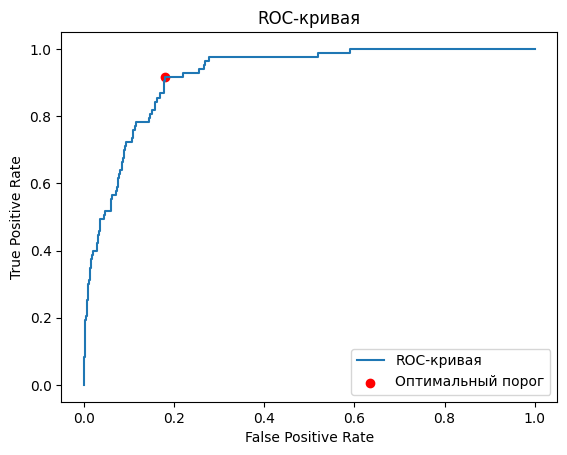

Fold 2
Оптимальный порог: 0.0699
TPR: 0.8205
FPR: 0.0988
Статистика Юдена: 0.7217
Матрица ошибок:
[[78600  8616]
 [   14    64]]
------------------------------


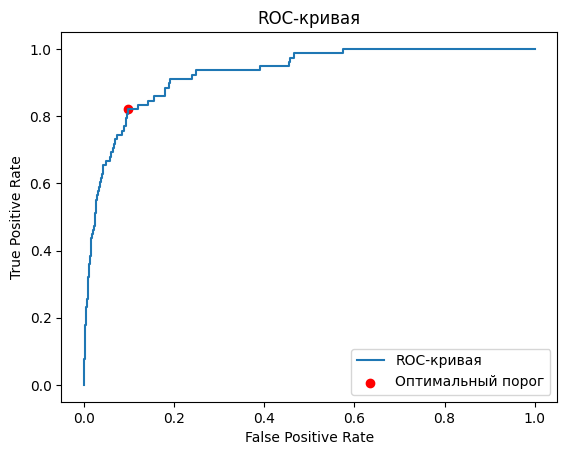

Fold 3
Оптимальный порог: 0.0193
TPR: 0.9000
FPR: 0.1205
Статистика Юдена: 0.7795
Матрица ошибок:
[[68238  9347]
 [    6    54]]
------------------------------


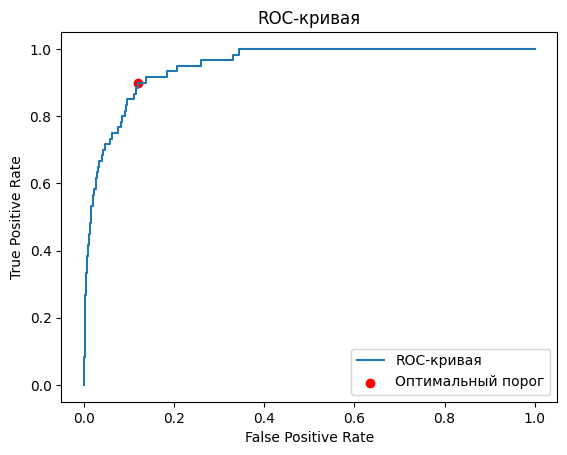

Fold 4
Оптимальный порог: 0.0088
TPR: 0.8427
FPR: 0.1413
Статистика Юдена: 0.7014
Матрица ошибок:
[[71508 11764]
 [   14    75]]
------------------------------


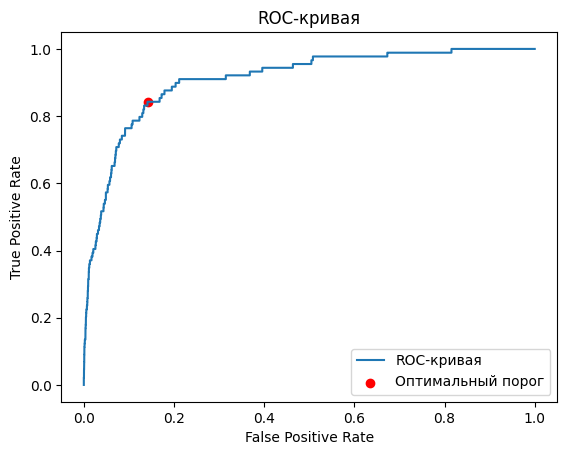

Fold 5
Оптимальный порог: 0.0061
TPR: 0.9036
FPR: 0.1742
Статистика Юдена: 0.7294
Матрица ошибок:
[[67311 14201]
 [    8    75]]
------------------------------


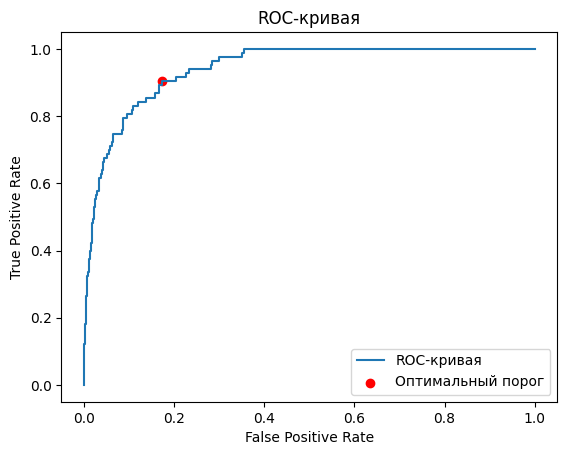

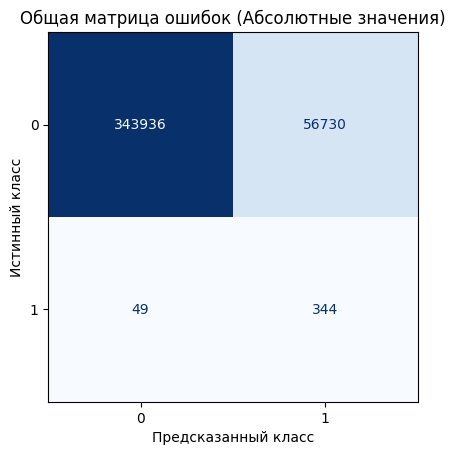

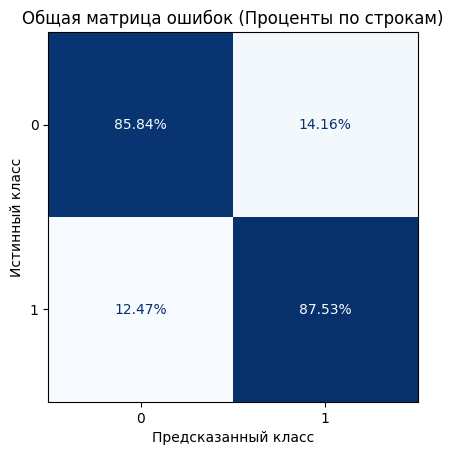

In [ ]:
# Списки для хранения confusion matrix и порогов вероятности каждого фолда
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (_, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Fold {fold+1}")

    model_weights = f'/content/ISIC_2024/models/exp3_EfficientNet_b0/exp3_fold{fold}.pth'
    model = CustomEfficientNetGem(pretrained=False)
    model.load_state_dict(torch.load(model_weights))
    model.to(device)
    model.eval()  # Устанавливаем режим оценки для модели

    # Достаем подмножество данных для текущего фолда
    val_metadata = metadata.iloc[val_idx].reset_index(drop=True)
    val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    # Списки для хранения истинных меток и предсказанных вероятностей
    y_true = []
    y_proba = []

    # Проходим по валидационному загрузчику и собираем предсказания и метки
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            # Получаем предсказания модели
            outputs = model(images).squeeze()
            probabilities = outputs.cpu().numpy()

            # Сохраняем предсказания и метки
            y_proba.extend(probabilities)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    # Вычисляем пороги и confusion matrix
    optimal_threshold, cm = calculate_confusion_matrix(y_true, y_proba, min_tpr=0.8)
    confusion_matrices.append(cm)
    optimal_thresholds.append(optimal_threshold)

# Сводим матрицы ошибок и визуализируем общую матрицу
total_cm_visualize(confusion_matrices)

## Итоги эксперимента
**Результат обучения:**  
СV pAUC: 0.1517  
Public Score pAUC: 0.1426

**Выводы:**
Результат улучшился и на валидационных и на тестовых данных. Попробую обучить другую модель с теми же параметрами.

**План дальнейшей работы:**
1. Обучить модель ResNet18.

# Эксперимент 4:
Обучил ResNet18 c такими же параметрами, по 40 эпох все 5 folds.

Параметры для обучения:  

| Параметр                | Значение                        |
|-------------------------|---------------------------------|
| Количество folds        | 5                               |
| Сколько folds обучаем   | 5                               |
| Предобученная модель    | 'resnet18'                      |
| Оптимизатор             | Adam(lr=1e-4, weight_decay=1e-4)|
| Планировщик скорости    | CosineAnnealingLR, T_max=500    |
| Количество эпох         | 40                              |
| Размер батча (train)    | 32                              |
| Размер батча (val)      | 64                              |
| Функция потерь          | BCELoss                         |


In [ ]:
# Трансформация для тренировочного набора, с аугментацией
train_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(p=0.5),
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

# Трансформация для валидационного набора, без аугментации
val_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

In [ ]:
# Инициализация StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [ ]:
# Класс для создания слоя Gem Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
# Класс для создания модели ResNet18 с GeM pooling
class CustomResNet18Gem(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=True):
        super(CustomResNet18Gem, self).__init__()

        # Создаем базовую модель ResNet18 через timm
        self.model = timm.create_model(model_name, pretrained=pretrained)

        # Убираем стандартный глобальный пулинг и классификатор
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()  # Удаление полносвязного слоя

        # Получаем количество входных фичей после свёрточной части
        in_features = self.model.num_features  # Это атрибут должен быть доступен для моделей timm

        # Добавляем GeM pooling
        self.gem_pooling = GeM()

        # Добавляем свой классификатор
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # Прогоняем через основную часть модели (свёрточную)
        x = self.model.forward_features(x)  # Этот метод должен существовать для моделей timm

        # Применяем GeM pooling
        x = self.gem_pooling(x)

        # Выравниваем для подачи в классификатор
        x = x.view(x.size(0), -1)

        # Пропускаем через классификатор
        x = self.classifier(x)

        # Применяем сигмоиду для получения вероятности класса
        x = torch.sigmoid(x)
        return x

Training fold 1
Pre-undersampling: Train size = 329895, Positive class = 310, Negative class = 329585
Validation size = 71164, Positive class = 83, Negative class = 71081
Post-undersampling: Balanced Train size = 6510, Positive class = 310, Negative class = 6200


Epoch 1 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.50it/s]


Epoch 1, Train Loss: 0.2473, Val Loss: 0.0737, pAUC: 0.0380, lr: 0.0001
Saved new best model with pAUC: 0.03797488458356435 on fold 0


Epoch 2 Validation: 100%|██████████| 1112/1112 [01:14<00:00, 14.92it/s]


Epoch 2, Train Loss: 0.1924, Val Loss: 0.0463, pAUC: 0.0566, lr: 9.999901304280685e-05
Saved new best model with pAUC: 0.0566149461593366 on fold 0


Epoch 3 Validation: 100%|██████████| 1112/1112 [01:14<00:00, 14.88it/s]


Epoch 3, Train Loss: 0.1827, Val Loss: 0.0555, pAUC: 0.0700, lr: 9.999605221019082e-05
Saved new best model with pAUC: 0.07003923743538465 on fold 0


Epoch 4 Validation: 100%|██████████| 1112/1112 [01:15<00:00, 14.67it/s]


Epoch 4, Train Loss: 0.1749, Val Loss: 0.0467, pAUC: 0.0811, lr: 9.999111761904047e-05
Saved new best model with pAUC: 0.0811116894810146 on fold 0


Epoch 5 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.11it/s]


Epoch 5, Train Loss: 0.1633, Val Loss: 0.0557, pAUC: 0.0962, lr: 9.998420946416502e-05
Saved new best model with pAUC: 0.09618721082328775 on fold 0


Epoch 6 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.11it/s]


Epoch 6, Train Loss: 0.1555, Val Loss: 0.0501, pAUC: 0.1031, lr: 9.997532801828661e-05
Saved new best model with pAUC: 0.10307895811379617 on fold 0


Epoch 7 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.29it/s]


Epoch 7, Train Loss: 0.1470, Val Loss: 0.0356, pAUC: 0.1249, lr: 9.996447363202949e-05
Saved new best model with pAUC: 0.12490098263935442 on fold 0


Epoch 8 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.26it/s]


Epoch 8, Train Loss: 0.1403, Val Loss: 0.0491, pAUC: 0.1181, lr: 9.995164673390628e-05


Epoch 9 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.24it/s]


Epoch 9, Train Loss: 0.1372, Val Loss: 0.0516, pAUC: 0.1139, lr: 9.993684783030092e-05


Epoch 10 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.54it/s]


Epoch 10, Train Loss: 0.1329, Val Loss: 0.0630, pAUC: 0.1282, lr: 9.992007750544879e-05
Saved new best model with pAUC: 0.12816693258310596 on fold 0


Epoch 11 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.30it/s]


Epoch 11, Train Loss: 0.1270, Val Loss: 0.0370, pAUC: 0.1157, lr: 9.990133642141361e-05


Epoch 12 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.57it/s]


Epoch 12, Train Loss: 0.1295, Val Loss: 0.0511, pAUC: 0.1169, lr: 9.988062531806129e-05


Epoch 13 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.35it/s]


Epoch 13, Train Loss: 0.1242, Val Loss: 0.0605, pAUC: 0.1301, lr: 9.985794501303072e-05
Saved new best model with pAUC: 0.13010531172395717 on fold 0


Epoch 14 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.29it/s]


Epoch 14, Train Loss: 0.1224, Val Loss: 0.0510, pAUC: 0.1319, lr: 9.983329640170151e-05
Saved new best model with pAUC: 0.131925414125375 on fold 0


Epoch 15 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.43it/s]


Epoch 15, Train Loss: 0.1201, Val Loss: 0.0374, pAUC: 0.1375, lr: 9.980668045715865e-05
Saved new best model with pAUC: 0.13746909812545433 on fold 0


Epoch 16 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.17it/s]


Epoch 16, Train Loss: 0.1218, Val Loss: 0.0439, pAUC: 0.1364, lr: 9.977809823015402e-05


Epoch 17 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.51it/s]


Epoch 17, Train Loss: 0.1184, Val Loss: 0.0504, pAUC: 0.1282, lr: 9.974755084906503e-05


Epoch 18 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.04it/s]


Epoch 18, Train Loss: 0.1155, Val Loss: 0.0660, pAUC: 0.1318, lr: 9.971503951984996e-05


Epoch 19 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.36it/s]


Epoch 19, Train Loss: 0.1153, Val Loss: 0.0587, pAUC: 0.1418, lr: 9.968056552600044e-05
Saved new best model with pAUC: 0.14176543542807007 on fold 0


Epoch 20 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.36it/s]


Epoch 20, Train Loss: 0.1105, Val Loss: 0.0355, pAUC: 0.1414, lr: 9.96441302284907e-05


Epoch 21 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.10it/s]


Epoch 21, Train Loss: 0.1105, Val Loss: 0.0339, pAUC: 0.1320, lr: 9.960573506572391e-05


Epoch 22 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.22it/s]


Epoch 22, Train Loss: 0.1110, Val Loss: 0.0420, pAUC: 0.1373, lr: 9.956538155347534e-05


Epoch 23 Validation: 100%|██████████| 1112/1112 [01:15<00:00, 14.75it/s]


Epoch 23, Train Loss: 0.1073, Val Loss: 0.0576, pAUC: 0.1409, lr: 9.952307128483256e-05


Epoch 24 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.47it/s]


Epoch 24, Train Loss: 0.0998, Val Loss: 0.0401, pAUC: 0.1401, lr: 9.947880593013255e-05


Epoch 25 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.27it/s]


Epoch 25, Train Loss: 0.1026, Val Loss: 0.0424, pAUC: 0.1443, lr: 9.94325872368957e-05
Saved new best model with pAUC: 0.144268383447833 on fold 0


Epoch 26 Validation: 100%|██████████| 1112/1112 [01:13<00:00, 15.05it/s]


Epoch 26, Train Loss: 0.1034, Val Loss: 0.0577, pAUC: 0.1513, lr: 9.93844170297569e-05
Saved new best model with pAUC: 0.15129398448028827 on fold 0


Epoch 27 Validation: 100%|██████████| 1112/1112 [01:10<00:00, 15.66it/s]


Epoch 27, Train Loss: 0.1037, Val Loss: 0.0605, pAUC: 0.1471, lr: 9.933429721039342e-05


Epoch 28 Validation: 100%|██████████| 1112/1112 [01:10<00:00, 15.78it/s]


Epoch 28, Train Loss: 0.1012, Val Loss: 0.0695, pAUC: 0.1426, lr: 9.928222975744993e-05


Epoch 29 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.59it/s]


Epoch 29, Train Loss: 0.0964, Val Loss: 0.0548, pAUC: 0.1415, lr: 9.92282167264603e-05


Epoch 30 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.29it/s]


Epoch 30, Train Loss: 0.0967, Val Loss: 0.0485, pAUC: 0.1427, lr: 9.917226024976651e-05


Epoch 31 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.62it/s]


Epoch 31, Train Loss: 0.0926, Val Loss: 0.0442, pAUC: 0.1469, lr: 9.911436253643447e-05


Epoch 32 Validation: 100%|██████████| 1112/1112 [01:10<00:00, 15.76it/s]


Epoch 32, Train Loss: 0.0909, Val Loss: 0.0388, pAUC: 0.1446, lr: 9.905452587216673e-05


Epoch 33 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.50it/s]


Epoch 33, Train Loss: 0.0869, Val Loss: 0.0529, pAUC: 0.1448, lr: 9.899275261921237e-05


Epoch 34 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.39it/s]


Epoch 34, Train Loss: 0.0830, Val Loss: 0.0542, pAUC: 0.1378, lr: 9.892904521627364e-05


Epoch 35 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.42it/s]


Epoch 35, Train Loss: 0.0826, Val Loss: 0.0395, pAUC: 0.1308, lr: 9.886340617840972e-05


Epoch 36 Validation: 100%|██████████| 1112/1112 [01:12<00:00, 15.36it/s]


Epoch 36, Train Loss: 0.0878, Val Loss: 0.0596, pAUC: 0.1294, lr: 9.879583809693741e-05


Epoch 37 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.49it/s]


Epoch 37, Train Loss: 0.0817, Val Loss: 0.0427, pAUC: 0.1374, lr: 9.87263436393289e-05


Epoch 38 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.63it/s]


Epoch 38, Train Loss: 0.0775, Val Loss: 0.0331, pAUC: 0.1273, lr: 9.865492554910636e-05


Epoch 39 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.56it/s]


Epoch 39, Train Loss: 0.0708, Val Loss: 0.0415, pAUC: 0.1292, lr: 9.858158664573372e-05


Epoch 40 Validation: 100%|██████████| 1112/1112 [01:11<00:00, 15.54it/s]


Epoch 40, Train Loss: 0.0738, Val Loss: 0.0393, pAUC: 0.1281, lr: 9.850632982450531e-05


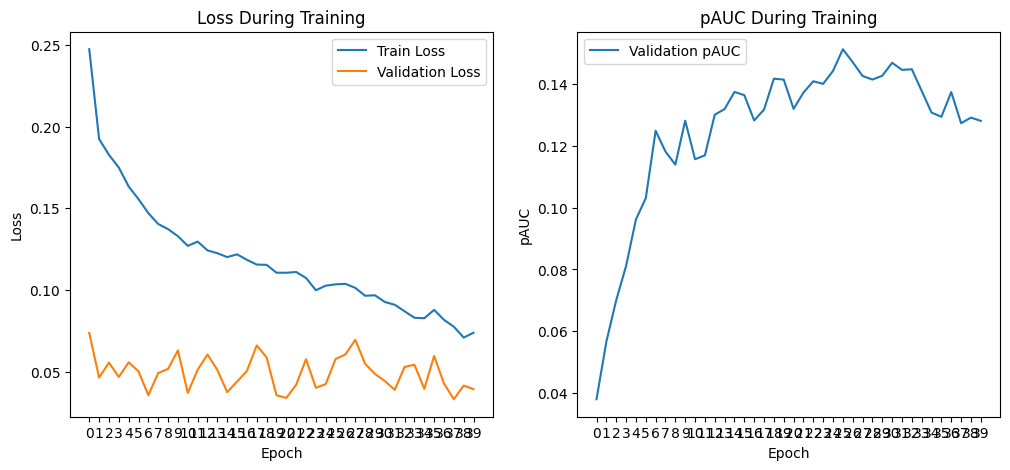

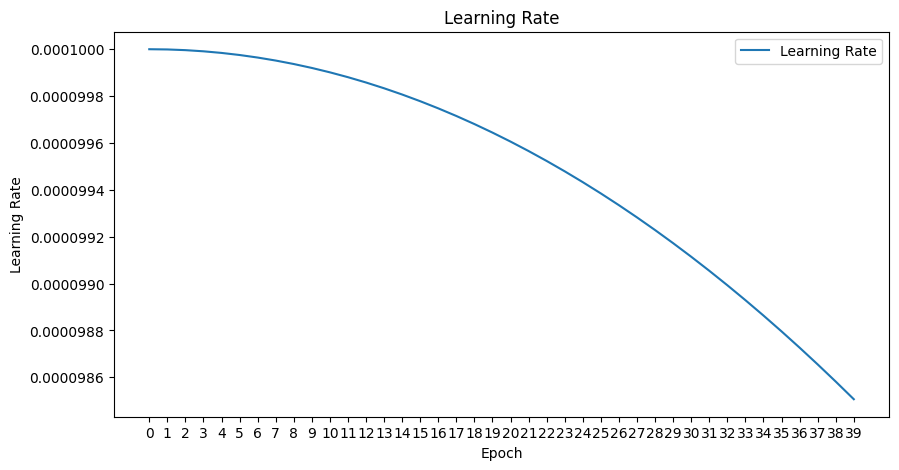

Training fold 2
Pre-undersampling: Train size = 313765, Positive class = 315, Negative class = 313450
Validation size = 87294, Positive class = 78, Negative class = 87216
Post-undersampling: Balanced Train size = 6615, Positive class = 315, Negative class = 6300


Epoch 1 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.42it/s]


Epoch 1, Train Loss: 0.2885, Val Loss: 0.0681, pAUC: 0.0267, lr: 0.0001
Saved new best model with pAUC: 0.026739859541180362 on fold 1


Epoch 2 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.60it/s]


Epoch 2, Train Loss: 0.1861, Val Loss: 0.0471, pAUC: 0.0572, lr: 9.999901304280685e-05
Saved new best model with pAUC: 0.057214801800657605 on fold 1


Epoch 3 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.56it/s]


Epoch 3, Train Loss: 0.1757, Val Loss: 0.0545, pAUC: 0.0800, lr: 9.999605221019082e-05
Saved new best model with pAUC: 0.08002214660683286 on fold 1


Epoch 4 Validation: 100%|██████████| 1364/1364 [01:26<00:00, 15.70it/s]


Epoch 4, Train Loss: 0.1637, Val Loss: 0.0614, pAUC: 0.1088, lr: 9.999111761904047e-05
Saved new best model with pAUC: 0.10882756751290047 on fold 1


Epoch 5 Validation: 100%|██████████| 1364/1364 [01:26<00:00, 15.70it/s]


Epoch 5, Train Loss: 0.1569, Val Loss: 0.0388, pAUC: 0.1220, lr: 9.998420946416502e-05
Saved new best model with pAUC: 0.12203097879005964 on fold 1


Epoch 6 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.56it/s]


Epoch 6, Train Loss: 0.1457, Val Loss: 0.0365, pAUC: 0.1181, lr: 9.997532801828661e-05


Epoch 7 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.52it/s]


Epoch 7, Train Loss: 0.1407, Val Loss: 0.0349, pAUC: 0.1300, lr: 9.996447363202949e-05
Saved new best model with pAUC: 0.13002395467310157 on fold 1


Epoch 8 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.39it/s]


Epoch 8, Train Loss: 0.1319, Val Loss: 0.0326, pAUC: 0.1285, lr: 9.995164673390628e-05


Epoch 9 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.64it/s]


Epoch 9, Train Loss: 0.1305, Val Loss: 0.0302, pAUC: 0.1211, lr: 9.993684783030092e-05


Epoch 10 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.53it/s]


Epoch 10, Train Loss: 0.1339, Val Loss: 0.0403, pAUC: 0.1264, lr: 9.992007750544879e-05


Epoch 11 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.91it/s]


Epoch 11, Train Loss: 0.1325, Val Loss: 0.0414, pAUC: 0.1220, lr: 9.990133642141361e-05


Epoch 12 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.36it/s]


Epoch 12, Train Loss: 0.1211, Val Loss: 0.0324, pAUC: 0.1214, lr: 9.988062531806129e-05


Epoch 13 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.57it/s]


Epoch 13, Train Loss: 0.1223, Val Loss: 0.0416, pAUC: 0.1339, lr: 9.985794501303072e-05
Saved new best model with pAUC: 0.1339442392362728 on fold 1


Epoch 14 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.31it/s]


Epoch 14, Train Loss: 0.1263, Val Loss: 0.0561, pAUC: 0.1404, lr: 9.983329640170151e-05
Saved new best model with pAUC: 0.14037436967575928 on fold 1


Epoch 15 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.34it/s]


Epoch 15, Train Loss: 0.1195, Val Loss: 0.0544, pAUC: 0.1393, lr: 9.980668045715865e-05


Epoch 16 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.40it/s]


Epoch 16, Train Loss: 0.1181, Val Loss: 0.0322, pAUC: 0.1373, lr: 9.977809823015402e-05


Epoch 17 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.31it/s]


Epoch 17, Train Loss: 0.1162, Val Loss: 0.0407, pAUC: 0.1329, lr: 9.974755084906503e-05


Epoch 18 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.87it/s]


Epoch 18, Train Loss: 0.1127, Val Loss: 0.0422, pAUC: 0.1354, lr: 9.971503951984996e-05


Epoch 19 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.85it/s]


Epoch 19, Train Loss: 0.1132, Val Loss: 0.0523, pAUC: 0.1392, lr: 9.968056552600044e-05


Epoch 20 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.27it/s]


Epoch 20, Train Loss: 0.1120, Val Loss: 0.0361, pAUC: 0.1438, lr: 9.96441302284907e-05
Saved new best model with pAUC: 0.14380907819783706 on fold 1


Epoch 21 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.48it/s]


Epoch 21, Train Loss: 0.1074, Val Loss: 0.0360, pAUC: 0.1366, lr: 9.960573506572391e-05


Epoch 22 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.28it/s]


Epoch 22, Train Loss: 0.1043, Val Loss: 0.0468, pAUC: 0.1492, lr: 9.956538155347534e-05
Saved new best model with pAUC: 0.14923830431019475 on fold 1


Epoch 23 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.19it/s]


Epoch 23, Train Loss: 0.1009, Val Loss: 0.0523, pAUC: 0.1507, lr: 9.952307128483256e-05
Saved new best model with pAUC: 0.15070323488045 on fold 1


Epoch 24 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.39it/s]


Epoch 24, Train Loss: 0.1007, Val Loss: 0.0639, pAUC: 0.1496, lr: 9.947880593013255e-05


Epoch 25 Validation: 100%|██████████| 1364/1364 [01:28<00:00, 15.40it/s]


Epoch 25, Train Loss: 0.0988, Val Loss: 0.0377, pAUC: 0.1439, lr: 9.94325872368957e-05


Epoch 26 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.22it/s]


Epoch 26, Train Loss: 0.1035, Val Loss: 0.0548, pAUC: 0.1376, lr: 9.93844170297569e-05


Epoch 27 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.17it/s]


Epoch 27, Train Loss: 0.0968, Val Loss: 0.0448, pAUC: 0.1370, lr: 9.933429721039342e-05


Epoch 28 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.96it/s]


Epoch 28, Train Loss: 0.0966, Val Loss: 0.0569, pAUC: 0.1430, lr: 9.928222975744993e-05


Epoch 29 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.22it/s]


Epoch 29, Train Loss: 0.0949, Val Loss: 0.0455, pAUC: 0.1461, lr: 9.92282167264603e-05


Epoch 30 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.19it/s]


Epoch 30, Train Loss: 0.0879, Val Loss: 0.0367, pAUC: 0.1438, lr: 9.917226024976651e-05


Epoch 31 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.20it/s]


Epoch 31, Train Loss: 0.0873, Val Loss: 0.0500, pAUC: 0.1538, lr: 9.911436253643447e-05
Saved new best model with pAUC: 0.153830028246993 on fold 1


Epoch 32 Validation: 100%|██████████| 1364/1364 [01:27<00:00, 15.51it/s]


Epoch 32, Train Loss: 0.0885, Val Loss: 0.0381, pAUC: 0.1434, lr: 9.905452587216673e-05


Epoch 33 Validation: 100%|██████████| 1364/1364 [01:32<00:00, 14.79it/s]


Epoch 33, Train Loss: 0.0885, Val Loss: 0.0497, pAUC: 0.1526, lr: 9.899275261921237e-05


Epoch 34 Validation: 100%|██████████| 1364/1364 [01:30<00:00, 15.06it/s]


Epoch 34, Train Loss: 0.0824, Val Loss: 0.0439, pAUC: 0.1444, lr: 9.892904521627364e-05


Epoch 35 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.24it/s]


Epoch 35, Train Loss: 0.0842, Val Loss: 0.0556, pAUC: 0.1414, lr: 9.886340617840972e-05


Epoch 36 Validation: 100%|██████████| 1364/1364 [01:30<00:00, 15.06it/s]


Epoch 36, Train Loss: 0.0794, Val Loss: 0.0398, pAUC: 0.1428, lr: 9.879583809693741e-05


Epoch 37 Validation: 100%|██████████| 1364/1364 [01:29<00:00, 15.31it/s]


Epoch 37, Train Loss: 0.0790, Val Loss: 0.0717, pAUC: 0.1495, lr: 9.87263436393289e-05


Epoch 38 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.94it/s]


Epoch 38, Train Loss: 0.0778, Val Loss: 0.0412, pAUC: 0.1394, lr: 9.865492554910636e-05


Epoch 39 Validation: 100%|██████████| 1364/1364 [01:31<00:00, 14.99it/s]


Epoch 39, Train Loss: 0.0798, Val Loss: 0.0731, pAUC: 0.1421, lr: 9.858158664573372e-05


Epoch 40 Validation: 100%|██████████| 1364/1364 [01:30<00:00, 15.07it/s]


Epoch 40, Train Loss: 0.0732, Val Loss: 0.0448, pAUC: 0.1352, lr: 9.850632982450531e-05


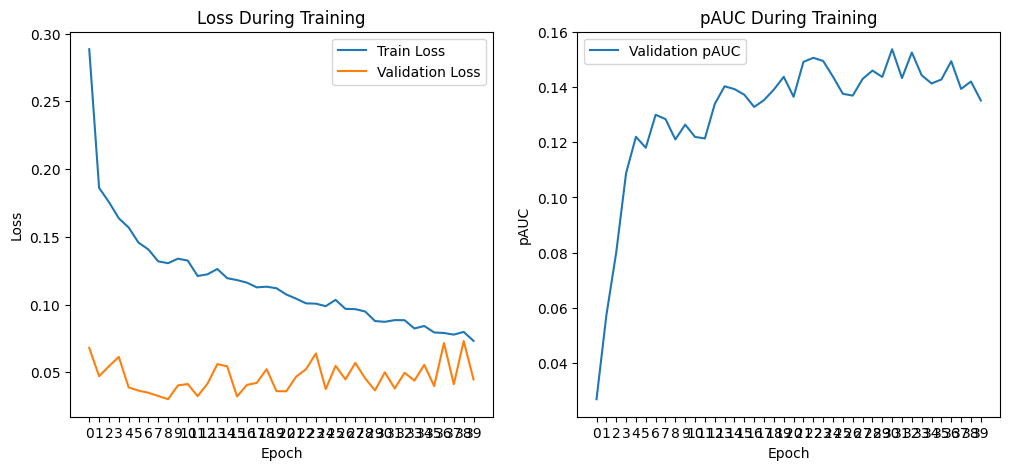

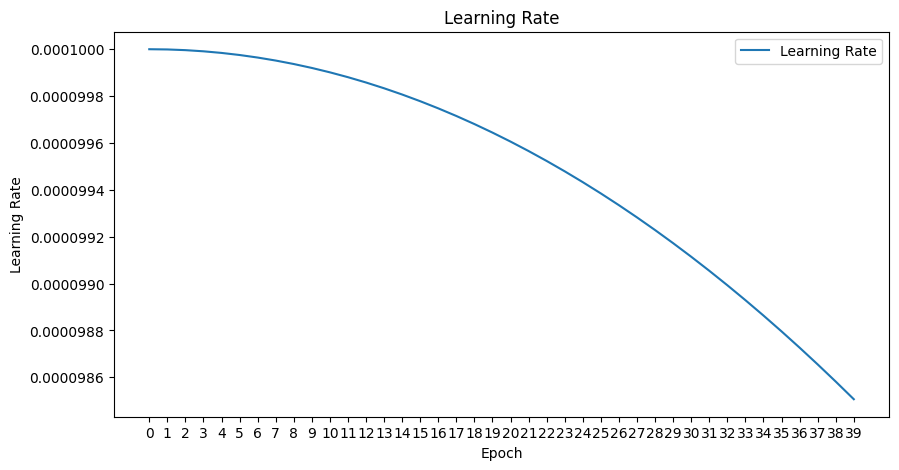

Training fold 3
Pre-undersampling: Train size = 323414, Positive class = 333, Negative class = 323081
Validation size = 77645, Positive class = 60, Negative class = 77585
Post-undersampling: Balanced Train size = 6993, Positive class = 333, Negative class = 6660


Epoch 1 Validation: 100%|██████████| 1214/1214 [01:20<00:00, 15.05it/s]


Epoch 1, Train Loss: 0.2162, Val Loss: 0.0576, pAUC: 0.0568, lr: 0.0001
Saved new best model with pAUC: 0.056764731155077186 on fold 2


Epoch 2 Validation: 100%|██████████| 1214/1214 [01:20<00:00, 15.08it/s]


Epoch 2, Train Loss: 0.1822, Val Loss: 0.0523, pAUC: 0.0731, lr: 9.999901304280685e-05
Saved new best model with pAUC: 0.07310132972438829 on fold 2


Epoch 3 Validation: 100%|██████████| 1214/1214 [01:21<00:00, 14.84it/s]


Epoch 3, Train Loss: 0.1752, Val Loss: 0.0512, pAUC: 0.0889, lr: 9.999605221019082e-05
Saved new best model with pAUC: 0.0889022792206397 on fold 2


Epoch 4 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.33it/s]


Epoch 4, Train Loss: 0.1623, Val Loss: 0.0376, pAUC: 0.1093, lr: 9.999111761904047e-05
Saved new best model with pAUC: 0.10926424781422525 on fold 2


Epoch 5 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.23it/s]


Epoch 5, Train Loss: 0.1593, Val Loss: 0.0393, pAUC: 0.1168, lr: 9.998420946416502e-05
Saved new best model with pAUC: 0.1167760091082898 on fold 2


Epoch 6 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.51it/s]


Epoch 6, Train Loss: 0.1515, Val Loss: 0.0294, pAUC: 0.1325, lr: 9.997532801828661e-05
Saved new best model with pAUC: 0.132499516659148 on fold 2


Epoch 7 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.39it/s]


Epoch 7, Train Loss: 0.1471, Val Loss: 0.0345, pAUC: 0.1313, lr: 9.996447363202949e-05


Epoch 8 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.29it/s]


Epoch 8, Train Loss: 0.1449, Val Loss: 0.0412, pAUC: 0.1392, lr: 9.995164673390628e-05
Saved new best model with pAUC: 0.13919872827651392 on fold 2


Epoch 9 Validation: 100%|██████████| 1214/1214 [01:22<00:00, 14.79it/s]


Epoch 9, Train Loss: 0.1383, Val Loss: 0.0444, pAUC: 0.1557, lr: 9.993684783030092e-05
Saved new best model with pAUC: 0.1557258705505789 on fold 2


Epoch 10 Validation: 100%|██████████| 1214/1214 [01:20<00:00, 15.06it/s]


Epoch 10, Train Loss: 0.1377, Val Loss: 0.0404, pAUC: 0.1533, lr: 9.992007750544879e-05


Epoch 11 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.28it/s]


Epoch 11, Train Loss: 0.1351, Val Loss: 0.0477, pAUC: 0.1625, lr: 9.990133642141361e-05
Saved new best model with pAUC: 0.16246138643638153 on fold 2


Epoch 12 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.37it/s]


Epoch 12, Train Loss: 0.1300, Val Loss: 0.0364, pAUC: 0.1598, lr: 9.988062531806129e-05


Epoch 13 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.38it/s]


Epoch 13, Train Loss: 0.1299, Val Loss: 0.0222, pAUC: 0.1554, lr: 9.985794501303072e-05


Epoch 14 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.34it/s]


Epoch 14, Train Loss: 0.1303, Val Loss: 0.0555, pAUC: 0.1538, lr: 9.983329640170151e-05


Epoch 15 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.30it/s]


Epoch 15, Train Loss: 0.1245, Val Loss: 0.0315, pAUC: 0.1622, lr: 9.980668045715865e-05


Epoch 16 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.67it/s]


Epoch 16, Train Loss: 0.1251, Val Loss: 0.0343, pAUC: 0.1556, lr: 9.977809823015402e-05


Epoch 17 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.23it/s]


Epoch 17, Train Loss: 0.1206, Val Loss: 0.0305, pAUC: 0.1415, lr: 9.974755084906503e-05


Epoch 18 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.38it/s]


Epoch 18, Train Loss: 0.1200, Val Loss: 0.0286, pAUC: 0.1513, lr: 9.971503951984996e-05


Epoch 19 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.52it/s]


Epoch 19, Train Loss: 0.1184, Val Loss: 0.0429, pAUC: 0.1620, lr: 9.968056552600044e-05


Epoch 20 Validation: 100%|██████████| 1214/1214 [01:20<00:00, 15.04it/s]


Epoch 20, Train Loss: 0.1161, Val Loss: 0.0353, pAUC: 0.1592, lr: 9.96441302284907e-05


Epoch 21 Validation: 100%|██████████| 1214/1214 [01:20<00:00, 15.09it/s]


Epoch 21, Train Loss: 0.1103, Val Loss: 0.0517, pAUC: 0.1645, lr: 9.960573506572391e-05
Saved new best model with pAUC: 0.16454039655431674 on fold 2


Epoch 22 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.59it/s]


Epoch 22, Train Loss: 0.1136, Val Loss: 0.0254, pAUC: 0.1639, lr: 9.956538155347534e-05


Epoch 23 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.57it/s]


Epoch 23, Train Loss: 0.1100, Val Loss: 0.0368, pAUC: 0.1466, lr: 9.952307128483256e-05


Epoch 24 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.56it/s]


Epoch 24, Train Loss: 0.1110, Val Loss: 0.0230, pAUC: 0.1550, lr: 9.947880593013255e-05


Epoch 25 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.67it/s]


Epoch 25, Train Loss: 0.1116, Val Loss: 0.0260, pAUC: 0.1547, lr: 9.94325872368957e-05


Epoch 26 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.49it/s]


Epoch 26, Train Loss: 0.0998, Val Loss: 0.0349, pAUC: 0.1658, lr: 9.93844170297569e-05
Saved new best model with pAUC: 0.1658131941311679 on fold 2


Epoch 27 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.42it/s]


Epoch 27, Train Loss: 0.0999, Val Loss: 0.0375, pAUC: 0.1653, lr: 9.933429721039342e-05


Epoch 28 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.58it/s]


Epoch 28, Train Loss: 0.0962, Val Loss: 0.0268, pAUC: 0.1634, lr: 9.928222975744993e-05


Epoch 29 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.57it/s]


Epoch 29, Train Loss: 0.0978, Val Loss: 0.0364, pAUC: 0.1662, lr: 9.92282167264603e-05
Saved new best model with pAUC: 0.16620405576679337 on fold 2


Epoch 30 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.58it/s]


Epoch 30, Train Loss: 0.0991, Val Loss: 0.0365, pAUC: 0.1555, lr: 9.917226024976651e-05


Epoch 31 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.53it/s]


Epoch 31, Train Loss: 0.0973, Val Loss: 0.0398, pAUC: 0.1668, lr: 9.911436253643447e-05
Saved new best model with pAUC: 0.1668260617387381 on fold 2


Epoch 32 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.47it/s]


Epoch 32, Train Loss: 0.0883, Val Loss: 0.0332, pAUC: 0.1642, lr: 9.905452587216673e-05


Epoch 33 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.62it/s]


Epoch 33, Train Loss: 0.0955, Val Loss: 0.0469, pAUC: 0.1565, lr: 9.899275261921237e-05


Epoch 34 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.51it/s]


Epoch 34, Train Loss: 0.0945, Val Loss: 0.0387, pAUC: 0.1658, lr: 9.892904521627364e-05


Epoch 35 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.50it/s]


Epoch 35, Train Loss: 0.0846, Val Loss: 0.0258, pAUC: 0.1658, lr: 9.886340617840972e-05


Epoch 36 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.31it/s]


Epoch 36, Train Loss: 0.0866, Val Loss: 0.0289, pAUC: 0.1630, lr: 9.879583809693741e-05


Epoch 37 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.52it/s]


Epoch 37, Train Loss: 0.0850, Val Loss: 0.0440, pAUC: 0.1588, lr: 9.87263436393289e-05


Epoch 38 Validation: 100%|██████████| 1214/1214 [01:19<00:00, 15.18it/s]


Epoch 38, Train Loss: 0.0823, Val Loss: 0.0215, pAUC: 0.1662, lr: 9.865492554910636e-05


Epoch 39 Validation: 100%|██████████| 1214/1214 [01:18<00:00, 15.51it/s]


Epoch 39, Train Loss: 0.0819, Val Loss: 0.0337, pAUC: 0.1688, lr: 9.858158664573372e-05
Saved new best model with pAUC: 0.16882494468432468 on fold 2


Epoch 40 Validation: 100%|██████████| 1214/1214 [01:17<00:00, 15.75it/s]


Epoch 40, Train Loss: 0.0811, Val Loss: 0.0359, pAUC: 0.1613, lr: 9.850632982450531e-05


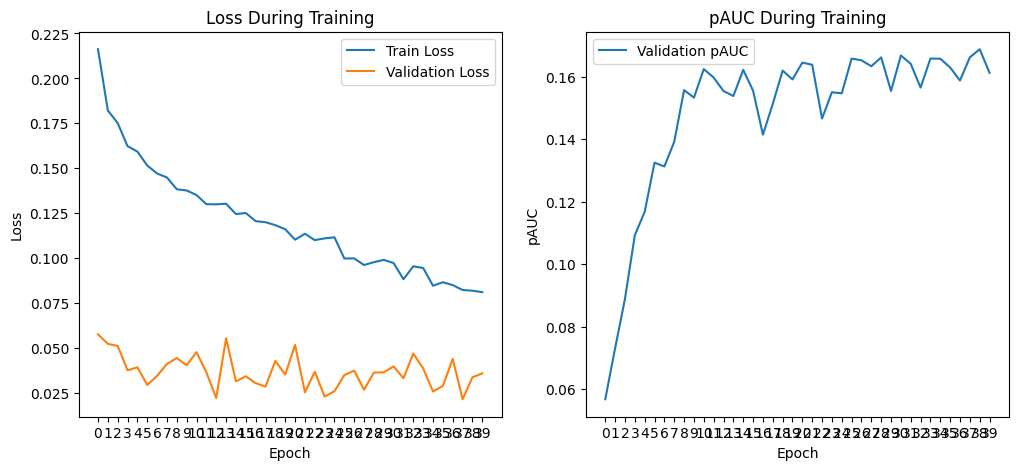

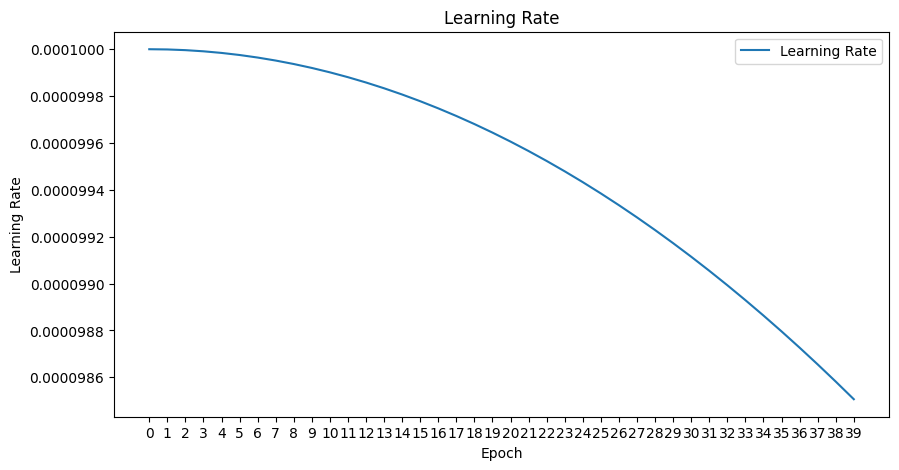

Training fold 4
Pre-undersampling: Train size = 317698, Positive class = 304, Negative class = 317394
Validation size = 83361, Positive class = 89, Negative class = 83272
Post-undersampling: Balanced Train size = 6384, Positive class = 304, Negative class = 6080


Epoch 1 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.68it/s]


Epoch 1, Train Loss: 0.2547, Val Loss: 0.0529, pAUC: 0.0434, lr: 0.0001
Saved new best model with pAUC: 0.04336429364821495 on fold 3


Epoch 2 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.62it/s]


Epoch 2, Train Loss: 0.1868, Val Loss: 0.0632, pAUC: 0.0654, lr: 9.999901304280685e-05
Saved new best model with pAUC: 0.06537710181659992 on fold 3


Epoch 3 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.56it/s]


Epoch 3, Train Loss: 0.1757, Val Loss: 0.0512, pAUC: 0.0833, lr: 9.999605221019082e-05
Saved new best model with pAUC: 0.08333965259104853 on fold 3


Epoch 4 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.78it/s]


Epoch 4, Train Loss: 0.1618, Val Loss: 0.0327, pAUC: 0.1036, lr: 9.999111761904047e-05
Saved new best model with pAUC: 0.10358455733532236 on fold 3


Epoch 5 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.33it/s]


Epoch 5, Train Loss: 0.1504, Val Loss: 0.0366, pAUC: 0.0957, lr: 9.998420946416502e-05


Epoch 6 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.67it/s]


Epoch 6, Train Loss: 0.1432, Val Loss: 0.0366, pAUC: 0.1084, lr: 9.997532801828661e-05
Saved new best model with pAUC: 0.10836674668960844 on fold 3


Epoch 7 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.65it/s]


Epoch 7, Train Loss: 0.1443, Val Loss: 0.0586, pAUC: 0.1103, lr: 9.996447363202949e-05
Saved new best model with pAUC: 0.11031474221206584 on fold 3


Epoch 8 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.74it/s]


Epoch 8, Train Loss: 0.1357, Val Loss: 0.0356, pAUC: 0.1150, lr: 9.995164673390628e-05
Saved new best model with pAUC: 0.11502378559608632 on fold 3


Epoch 9 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.56it/s]


Epoch 9, Train Loss: 0.1331, Val Loss: 0.0631, pAUC: 0.1278, lr: 9.993684783030092e-05
Saved new best model with pAUC: 0.1277776443462388 on fold 3


Epoch 10 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.43it/s]


Epoch 10, Train Loss: 0.1243, Val Loss: 0.0648, pAUC: 0.1267, lr: 9.992007750544879e-05


Epoch 11 Validation: 100%|██████████| 1303/1303 [01:25<00:00, 15.16it/s]


Epoch 11, Train Loss: 0.1248, Val Loss: 0.0668, pAUC: 0.1302, lr: 9.990133642141361e-05
Saved new best model with pAUC: 0.13021820464356143 on fold 3


Epoch 12 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.42it/s]


Epoch 12, Train Loss: 0.1237, Val Loss: 0.0399, pAUC: 0.1251, lr: 9.988062531806129e-05


Epoch 13 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.53it/s]


Epoch 13, Train Loss: 0.1181, Val Loss: 0.0380, pAUC: 0.1383, lr: 9.985794501303072e-05
Saved new best model with pAUC: 0.13826681156432255 on fold 3


Epoch 14 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.40it/s]


Epoch 14, Train Loss: 0.1162, Val Loss: 0.0521, pAUC: 0.1245, lr: 9.983329640170151e-05


Epoch 15 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.38it/s]


Epoch 15, Train Loss: 0.1131, Val Loss: 0.0306, pAUC: 0.1221, lr: 9.980668045715865e-05


Epoch 16 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.65it/s]


Epoch 16, Train Loss: 0.1173, Val Loss: 0.0457, pAUC: 0.1309, lr: 9.977809823015402e-05


Epoch 17 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.40it/s]


Epoch 17, Train Loss: 0.1109, Val Loss: 0.0439, pAUC: 0.1154, lr: 9.974755084906503e-05


Epoch 18 Validation: 100%|██████████| 1303/1303 [01:24<00:00, 15.35it/s]


Epoch 18, Train Loss: 0.1087, Val Loss: 0.0518, pAUC: 0.1171, lr: 9.971503951984996e-05


Epoch 19 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.75it/s]


Epoch 19, Train Loss: 0.1083, Val Loss: 0.0433, pAUC: 0.1229, lr: 9.968056552600044e-05


Epoch 20 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.74it/s]


Epoch 20, Train Loss: 0.1042, Val Loss: 0.0584, pAUC: 0.1219, lr: 9.96441302284907e-05


Epoch 21 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.64it/s]


Epoch 21, Train Loss: 0.1010, Val Loss: 0.0410, pAUC: 0.1164, lr: 9.960573506572391e-05


Epoch 22 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.71it/s]


Epoch 22, Train Loss: 0.1013, Val Loss: 0.0405, pAUC: 0.1314, lr: 9.956538155347534e-05


Epoch 23 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.53it/s]


Epoch 23, Train Loss: 0.1006, Val Loss: 0.0528, pAUC: 0.1206, lr: 9.952307128483256e-05


Epoch 24 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.64it/s]


Epoch 24, Train Loss: 0.0995, Val Loss: 0.0309, pAUC: 0.1259, lr: 9.947880593013255e-05


Epoch 25 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.71it/s]


Epoch 25, Train Loss: 0.0934, Val Loss: 0.0278, pAUC: 0.1232, lr: 9.94325872368957e-05


Epoch 26 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.73it/s]


Epoch 26, Train Loss: 0.0945, Val Loss: 0.0467, pAUC: 0.1235, lr: 9.93844170297569e-05


Epoch 27 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.72it/s]


Epoch 27, Train Loss: 0.0909, Val Loss: 0.0375, pAUC: 0.1289, lr: 9.933429721039342e-05


Epoch 28 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.63it/s]


Epoch 28, Train Loss: 0.0924, Val Loss: 0.0458, pAUC: 0.1321, lr: 9.928222975744993e-05


Epoch 29 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.53it/s]


Epoch 29, Train Loss: 0.0909, Val Loss: 0.0243, pAUC: 0.1132, lr: 9.92282167264603e-05


Epoch 30 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.54it/s]


Epoch 30, Train Loss: 0.0845, Val Loss: 0.0615, pAUC: 0.1246, lr: 9.917226024976651e-05


Epoch 31 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.58it/s]


Epoch 31, Train Loss: 0.0864, Val Loss: 0.0342, pAUC: 0.1101, lr: 9.911436253643447e-05


Epoch 32 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.63it/s]


Epoch 32, Train Loss: 0.0857, Val Loss: 0.0418, pAUC: 0.1213, lr: 9.905452587216673e-05


Epoch 33 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.60it/s]


Epoch 33, Train Loss: 0.0776, Val Loss: 0.0421, pAUC: 0.1193, lr: 9.899275261921237e-05


Epoch 34 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.53it/s]


Epoch 34, Train Loss: 0.0793, Val Loss: 0.0431, pAUC: 0.1163, lr: 9.892904521627364e-05


Epoch 35 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.62it/s]


Epoch 35, Train Loss: 0.0800, Val Loss: 0.0358, pAUC: 0.1112, lr: 9.886340617840972e-05


Epoch 36 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.63it/s]


Epoch 36, Train Loss: 0.0726, Val Loss: 0.0332, pAUC: 0.1056, lr: 9.879583809693741e-05


Epoch 37 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.65it/s]


Epoch 37, Train Loss: 0.0751, Val Loss: 0.0410, pAUC: 0.1133, lr: 9.87263436393289e-05


Epoch 38 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.67it/s]


Epoch 38, Train Loss: 0.0715, Val Loss: 0.0364, pAUC: 0.1126, lr: 9.865492554910636e-05


Epoch 39 Validation: 100%|██████████| 1303/1303 [01:23<00:00, 15.63it/s]


Epoch 39, Train Loss: 0.0753, Val Loss: 0.0617, pAUC: 0.1184, lr: 9.858158664573372e-05


Epoch 40 Validation: 100%|██████████| 1303/1303 [01:22<00:00, 15.72it/s]


Epoch 40, Train Loss: 0.0664, Val Loss: 0.0276, pAUC: 0.1166, lr: 9.850632982450531e-05


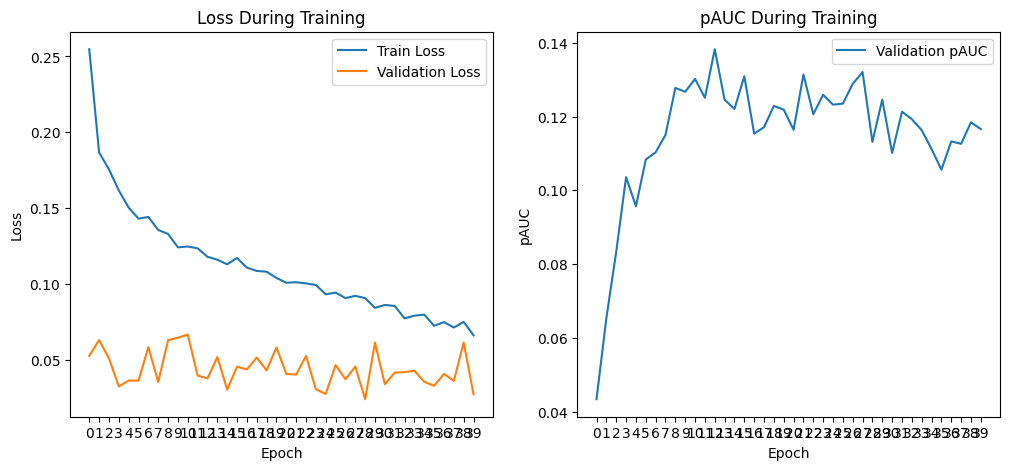

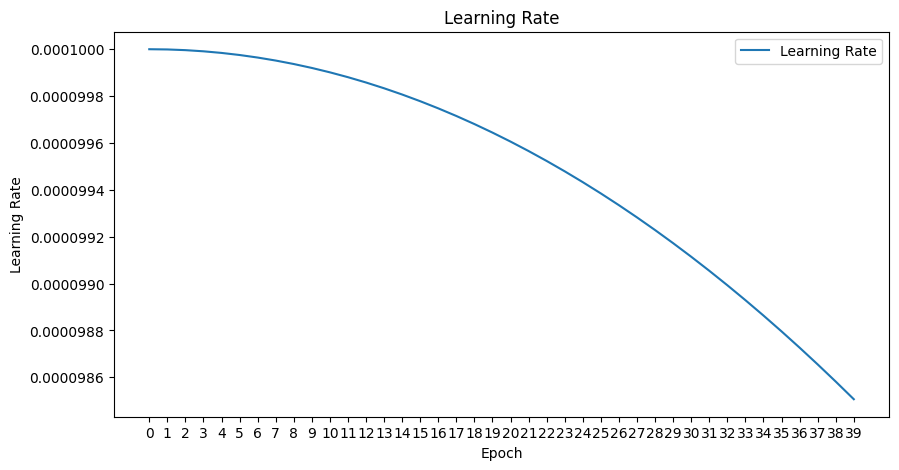

Training fold 5
Pre-undersampling: Train size = 319464, Positive class = 310, Negative class = 319154
Validation size = 81595, Positive class = 83, Negative class = 81512
Post-undersampling: Balanced Train size = 6510, Positive class = 310, Negative class = 6200


Epoch 1 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.73it/s]


Epoch 1, Train Loss: 0.2317, Val Loss: 0.0597, pAUC: 0.0449, lr: 0.0001
Saved new best model with pAUC: 0.044889155207541304 on fold 4


Epoch 2 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.44it/s]


Epoch 2, Train Loss: 0.1853, Val Loss: 0.0506, pAUC: 0.0808, lr: 9.999901304280685e-05
Saved new best model with pAUC: 0.08083563718018602 on fold 4


Epoch 3 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.37it/s]


Epoch 3, Train Loss: 0.1750, Val Loss: 0.0648, pAUC: 0.1022, lr: 9.999605221019082e-05
Saved new best model with pAUC: 0.10216445327881352 on fold 4


Epoch 4 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.65it/s]


Epoch 4, Train Loss: 0.1650, Val Loss: 0.0482, pAUC: 0.1047, lr: 9.999111761904047e-05
Saved new best model with pAUC: 0.1047216641617998 on fold 4


Epoch 5 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.58it/s]


Epoch 5, Train Loss: 0.1534, Val Loss: 0.0429, pAUC: 0.1258, lr: 9.998420946416502e-05
Saved new best model with pAUC: 0.1258333904860781 on fold 4


Epoch 6 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.56it/s]


Epoch 6, Train Loss: 0.1489, Val Loss: 0.0572, pAUC: 0.1200, lr: 9.997532801828661e-05


Epoch 7 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.64it/s]


Epoch 7, Train Loss: 0.1450, Val Loss: 0.0560, pAUC: 0.1382, lr: 9.996447363202949e-05
Saved new best model with pAUC: 0.1382217948247992 on fold 4


Epoch 8 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.61it/s]


Epoch 8, Train Loss: 0.1423, Val Loss: 0.0345, pAUC: 0.1322, lr: 9.995164673390628e-05


Epoch 9 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.60it/s]


Epoch 9, Train Loss: 0.1407, Val Loss: 0.0323, pAUC: 0.1362, lr: 9.993684783030092e-05


Epoch 10 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.66it/s]


Epoch 10, Train Loss: 0.1358, Val Loss: 0.0391, pAUC: 0.1376, lr: 9.992007750544879e-05


Epoch 11 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.62it/s]


Epoch 11, Train Loss: 0.1328, Val Loss: 0.0440, pAUC: 0.1363, lr: 9.990133642141361e-05


Epoch 12 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.65it/s]


Epoch 12, Train Loss: 0.1320, Val Loss: 0.0432, pAUC: 0.1345, lr: 9.988062531806129e-05


Epoch 13 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.60it/s]


Epoch 13, Train Loss: 0.1311, Val Loss: 0.0463, pAUC: 0.1458, lr: 9.985794501303072e-05
Saved new best model with pAUC: 0.14584738502542902 on fold 4


Epoch 14 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.53it/s]


Epoch 14, Train Loss: 0.1291, Val Loss: 0.0362, pAUC: 0.1398, lr: 9.983329640170151e-05


Epoch 15 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.58it/s]


Epoch 15, Train Loss: 0.1252, Val Loss: 0.0350, pAUC: 0.1280, lr: 9.980668045715865e-05


Epoch 16 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.58it/s]


Epoch 16, Train Loss: 0.1234, Val Loss: 0.0404, pAUC: 0.1479, lr: 9.977809823015402e-05
Saved new best model with pAUC: 0.14788333331362544 on fold 4


Epoch 17 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.59it/s]


Epoch 17, Train Loss: 0.1208, Val Loss: 0.0469, pAUC: 0.1460, lr: 9.974755084906503e-05


Epoch 18 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.62it/s]


Epoch 18, Train Loss: 0.1184, Val Loss: 0.0509, pAUC: 0.1495, lr: 9.971503951984996e-05
Saved new best model with pAUC: 0.14948169358166788 on fold 4


Epoch 19 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.66it/s]


Epoch 19, Train Loss: 0.1139, Val Loss: 0.0471, pAUC: 0.1384, lr: 9.968056552600044e-05


Epoch 20 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.57it/s]


Epoch 20, Train Loss: 0.1123, Val Loss: 0.0701, pAUC: 0.1505, lr: 9.96441302284907e-05
Saved new best model with pAUC: 0.15053837885647997 on fold 4


Epoch 21 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.46it/s]


Epoch 21, Train Loss: 0.1116, Val Loss: 0.0576, pAUC: 0.1505, lr: 9.960573506572391e-05


Epoch 22 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.64it/s]


Epoch 22, Train Loss: 0.1115, Val Loss: 0.0297, pAUC: 0.1611, lr: 9.956538155347534e-05
Saved new best model with pAUC: 0.16112305734864074 on fold 4


Epoch 23 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.65it/s]


Epoch 23, Train Loss: 0.1099, Val Loss: 0.0346, pAUC: 0.1599, lr: 9.952307128483256e-05


Epoch 24 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.52it/s]


Epoch 24, Train Loss: 0.1183, Val Loss: 0.0448, pAUC: 0.1554, lr: 9.947880593013255e-05


Epoch 25 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.57it/s]


Epoch 25, Train Loss: 0.1093, Val Loss: 0.0474, pAUC: 0.1551, lr: 9.94325872368957e-05


Epoch 26 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.58it/s]


Epoch 26, Train Loss: 0.1112, Val Loss: 0.0408, pAUC: 0.1527, lr: 9.93844170297569e-05


Epoch 27 Validation: 100%|██████████| 1275/1275 [01:23<00:00, 15.34it/s]


Epoch 27, Train Loss: 0.0974, Val Loss: 0.0423, pAUC: 0.1535, lr: 9.933429721039342e-05


Epoch 28 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.45it/s]


Epoch 28, Train Loss: 0.1092, Val Loss: 0.0355, pAUC: 0.1606, lr: 9.928222975744993e-05


Epoch 29 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.61it/s]


Epoch 29, Train Loss: 0.1003, Val Loss: 0.0601, pAUC: 0.1590, lr: 9.92282167264603e-05


Epoch 30 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.63it/s]


Epoch 30, Train Loss: 0.0961, Val Loss: 0.0408, pAUC: 0.1586, lr: 9.917226024976651e-05


Epoch 31 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.62it/s]


Epoch 31, Train Loss: 0.1036, Val Loss: 0.0323, pAUC: 0.1637, lr: 9.911436253643447e-05
Saved new best model with pAUC: 0.16366865045814813 on fold 4


Epoch 32 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.71it/s]


Epoch 32, Train Loss: 0.0928, Val Loss: 0.0508, pAUC: 0.1564, lr: 9.905452587216673e-05


Epoch 33 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.70it/s]


Epoch 33, Train Loss: 0.0946, Val Loss: 0.0440, pAUC: 0.1522, lr: 9.899275261921237e-05


Epoch 34 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.68it/s]


Epoch 34, Train Loss: 0.0888, Val Loss: 0.0369, pAUC: 0.1578, lr: 9.892904521627364e-05


Epoch 35 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.70it/s]


Epoch 35, Train Loss: 0.0855, Val Loss: 0.0600, pAUC: 0.1585, lr: 9.886340617840972e-05


Epoch 36 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.61it/s]


Epoch 36, Train Loss: 0.0846, Val Loss: 0.0435, pAUC: 0.1587, lr: 9.879583809693741e-05


Epoch 37 Validation: 100%|██████████| 1275/1275 [01:22<00:00, 15.52it/s]


Epoch 37, Train Loss: 0.0867, Val Loss: 0.0680, pAUC: 0.1584, lr: 9.87263436393289e-05


Epoch 38 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.63it/s]


Epoch 38, Train Loss: 0.0825, Val Loss: 0.0526, pAUC: 0.1604, lr: 9.865492554910636e-05


Epoch 39 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.62it/s]


Epoch 39, Train Loss: 0.0819, Val Loss: 0.0499, pAUC: 0.1566, lr: 9.858158664573372e-05


Epoch 40 Validation: 100%|██████████| 1275/1275 [01:21<00:00, 15.58it/s]


Epoch 40, Train Loss: 0.0783, Val Loss: 0.0476, pAUC: 0.1641, lr: 9.850632982450531e-05
Saved new best model with pAUC: 0.16408517572104092 on fold 4


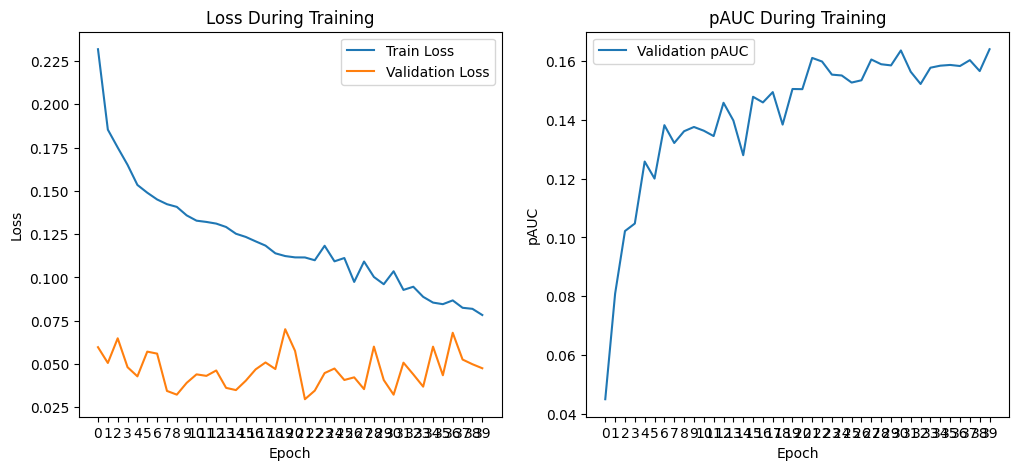

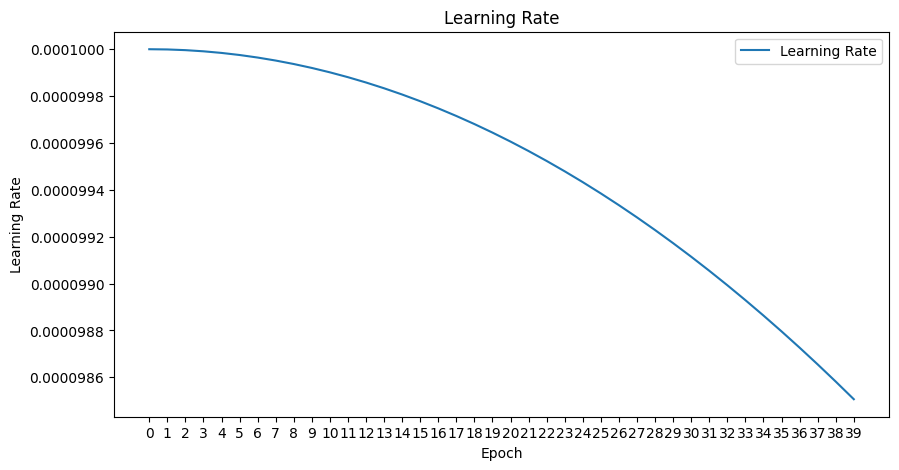

In [ ]:
# Обучение ResNet18 5 folds, downsampling 20:1
exp_num = 4
model_name = 'resnet18'
ratio = 20
num_epochs = 40
criterion = nn.BCELoss()
history_list = []
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (train_idx, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Training fold {fold+1}")

    model = CustomResNet18Gem(model_name)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=500)

    # Достаем подмножество данных для текущего фолда
    train_metadata = metadata.iloc[train_idx]
    val_metadata = metadata.iloc[val_idx]

    # Выводим статистику до ресэмплинга
    print(f"Pre-undersampling: Train size = {len(train_metadata)}, Positive class = {sum(train_metadata['target']==1)}, Negative class = {sum(train_metadata['target']==0)}")
    print(f"Validation size = {len(val_metadata)}, Positive class = {sum(val_metadata['target']==1)}, Negative class = {sum(val_metadata['target']==0)}")

    # Применяем undersampling
    majority_class = train_metadata[train_metadata['target'] == 0]
    minority_class = train_metadata[train_metadata['target'] == 1]

    # Ресэмплинг большего класса до размера меньшего класса
    majority_downsampled = resample(majority_class,
                                    replace=False,  # без возвращения
                                    n_samples=len(minority_class)*ratio,  # соотношение 20:1
                                    random_state=seed_value)  # для воспроизводимости

    # Объединяем сбалансированный больший класс с меньшим классом
    balanced_train_metadata = pd.concat([majority_downsampled, minority_class])

    # Перемешиваем данные
    balanced_train_metadata = balanced_train_metadata.sample(frac=1, random_state=seed_value).reset_index(drop=True)

    # Вывод статистики после ресэмплинга
    print(f"Post-undersampling: Balanced Train size = {len(balanced_train_metadata)}, Positive class = {sum(balanced_train_metadata['target']==1)}, Negative class = {sum(balanced_train_metadata['target']==0)}")

    train_data = HDF5Dataset(data_path, balanced_train_metadata, transform=train_transform)
    val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    history, optimal_threshold, cm = train_model(model,
                                                 train_loader,
                                                 val_loader,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs,
                                                 device,
                                                 exp_num,
                                                 model_name,
                                                 project_dir,
                                                 fold,
                                                 checkpoint_save=False,
                                                 min_tpr=0.8,
                                                 )
    # Записываем историю обучения по фолду
    history_list.append(history)
    optimal_thresholds.append(optimal_threshold)
    confusion_matrices.append(cm)

In [ ]:
# Визуализируем общую матрицу ошибок
total_cm_visualize(confusion_matrices)

In [ ]:
# Выводим результаты val_pAUC по всем фолдам
crossvalidation_results(history_list)

In [ ]:
# Считаем показатели моделей по кроссвалидации
best_pAUCs = [0.1513, 0.1538, 0.1688, 0.1383, 0.1641]
cv_pAUC = round(np.mean(best_pAUCs), 4)
print(f'CV: {cv_pAUC}')
print('LB: 0.1501')

CV: 0.1553
LB: 0.1501


## Confusion Matrix эксперимент 4
Этот раздел нужен только для демонстрации Confusion Matrix для ранее обученных моделей (в предудущих сеансах). Позже добавил этот функционал в функцию train_model, при новом запуске ячеек обучения моделей confusion matrix рассчитывается, и этот раздел не нужен.

In [ ]:
# Загружаем модели
url = 'https://drive.google.com/uc?id=1fFytj7tZRnguXaihxYI-yZqSjBZTmNr9'
models_dir = os.path.join(project_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
output_archive = 'exp4_resnet18.zip'
download_and_extract(url, output_archive, models_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1fFytj7tZRnguXaihxYI-yZqSjBZTmNr9
From (redirected): https://drive.google.com/uc?id=1fFytj7tZRnguXaihxYI-yZqSjBZTmNr9&confirm=t&uuid=456cc4ff-e0f1-4303-af6a-d0e7d1802b7d
To: /content/exp4_resnet18.zip
100%|██████████| 209M/209M [00:09<00:00, 22.1MB/s]


Fold 1
Оптимальный порог: 0.0480
TPR: 0.9157
FPR: 0.1376
Статистика Юдена: 0.7780
Матрица ошибок:
[[61297  9784]
 [    7    76]]
------------------------------


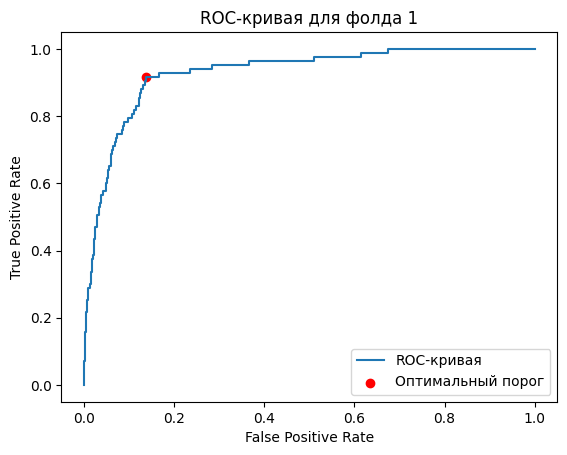

Fold 2
Оптимальный порог: 0.0114
TPR: 0.9487
FPR: 0.2228
Статистика Юдена: 0.7259
Матрица ошибок:
[[67780 19436]
 [    4    74]]
------------------------------


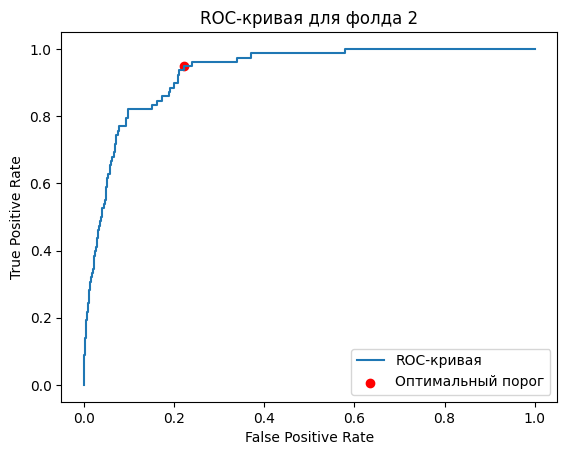

Fold 3
Оптимальный порог: 0.0105
TPR: 0.9500
FPR: 0.1749
Статистика Юдена: 0.7751
Матрица ошибок:
[[64015 13570]
 [    3    57]]
------------------------------


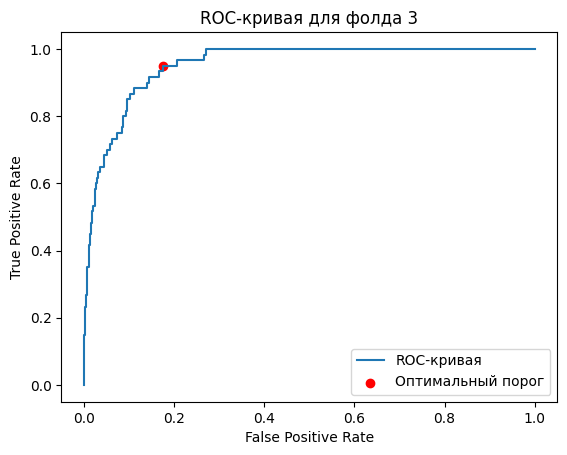

Fold 4
Оптимальный порог: 0.0195
TPR: 0.8764
FPR: 0.2115
Статистика Юдена: 0.6650
Матрица ошибок:
[[65664 17608]
 [   11    78]]
------------------------------


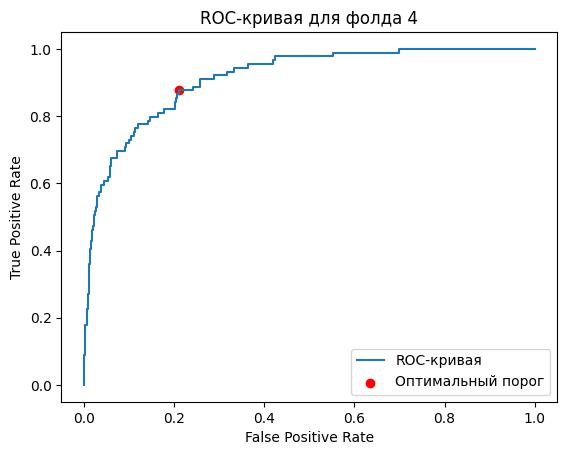

Fold 5
Оптимальный порог: 0.0428
TPR: 0.9036
FPR: 0.1186
Статистика Юдена: 0.7850
Матрица ошибок:
[[71843  9669]
 [    8    75]]
------------------------------


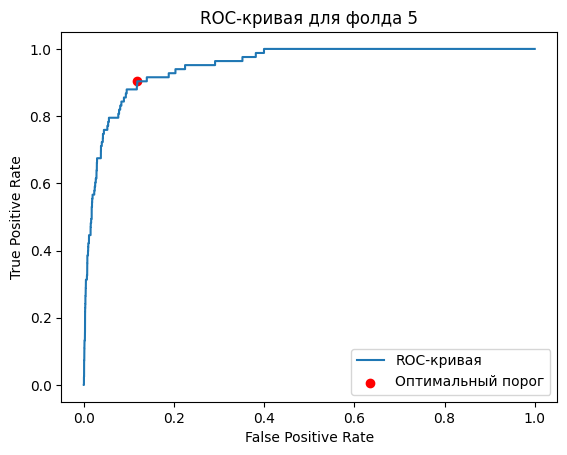

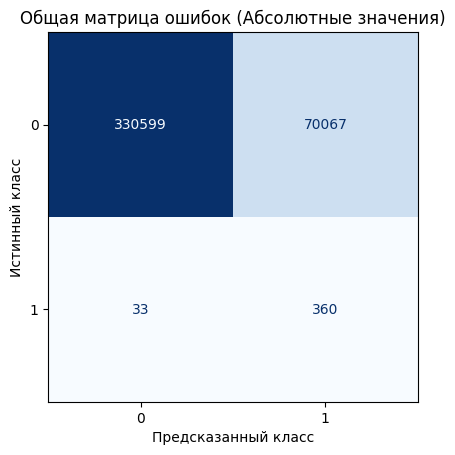

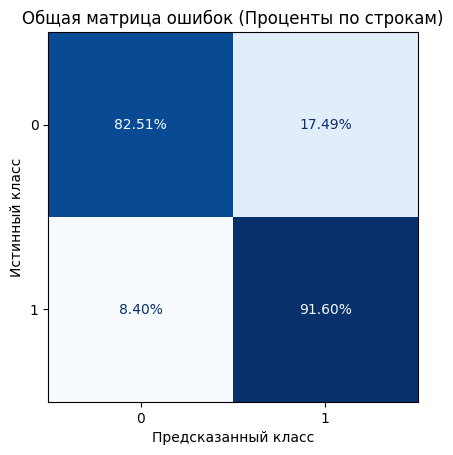

In [ ]:
# Списки для хранения confusion matrix и порогов вероятности каждого фолда
optimal_thresholds = []
confusion_matrices = []

# Цикл по фолдам кросс-валидации
for fold, (_, val_idx) in enumerate(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id'])):
    print(f"Fold {fold+1}")

    model_weights = f'/content/ISIC_2024/models/exp4_ResNet18/exp4_fold{fold}.pth'
    model = CustomResNet18Gem(pretrained=False)
    model.load_state_dict(torch.load(model_weights))
    model.to(device)
    model.eval()  # Устанавливаем режим оценки для модели

    # Достаем подмножество данных для текущего фолда
    val_metadata = metadata.iloc[val_idx].reset_index(drop=True)
    val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

    # Списки для хранения истинных меток и предсказанных вероятностей
    y_true = []
    y_proba = []

    # Проходим по валидационному загрузчику и собираем предсказания и метки
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            # Получаем предсказания модели
            outputs = model(images).squeeze()
            probabilities = outputs.cpu().numpy()

            # Сохраняем предсказания и метки
            y_proba.extend(probabilities)
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    # Вычисляем пороги и confusion matrix
    optimal_threshold, cm = calculate_confusion_matrix(y_true, y_proba, min_tpr=0.8)
    confusion_matrices.append(cm)
    optimal_thresholds.append(optimal_threshold)

# Сводим матрицы ошибок и визуализируем общую матрицу
total_cm_visualize(confusion_matrices)

## Итоги эксперимента
**Результат обучения:**  
СV pAUC: 0.1553  
Public Score pAUC: 0.1501

**Выводы:**
Модели, обученные в этом эксперименте показали наилучший результат по показателям CV pAUC и Public Score pAUC.
Цель по показателю Public Score pAUC > 0.15 достигнута.

# Итоговые результаты по всем экспериментам:  

| Эксперимент | CV pAUC   | Public Score pAUC |  TPR    |  FPR    | Youden's J |
|-------------|---------- |-------------------|-------  |-------  |------------|
| exp1        | 0.1453    | 0.13533           |         |         |            |
| exp2        | 0.1477    | 0.13418           |0.855    |**0.1243**|0.7307     |
| exp3        | 0.1517    | 0.1426            |0.8753   |0.1416   | 0.7337     |
| exp4        | **0.1553**| **0.1501**        |**0.916**|0.1749   | **0.7411** |

<br>

**Выводы:** Модели, обученные на 4 эксперименте (ResNet18 с применением undersampling) показали наилучший результат. Для достижения более высокого результата необходимо добавлять анализ табличных данных.

# Эксперимент 5:
Так как тестовые данные в конкурсе недоступны, для демонстрации работы модели на тестовой выборке выделил 10% датасета на тестовую выборку, 10% на валидационную, и обучил модель с архитектурой из лучшего 4 эксперимента без кроссвалидации.

In [ ]:
# Трансформация для тренировочного набора, с аугментацией
train_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(p=0.5),
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

# Трансформация для валидационного набора, без аугментации
val_transform = A.Compose([
    A.Resize(height=224, width=224), #resize
    A.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
])

In [ ]:
# Класс для создания слоя Gem Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
# Класс для создания модели ResNet18 с GeM pooling
class CustomResNet18Gem(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=True):
        super(CustomResNet18Gem, self).__init__()

        # Создаем базовую модель ResNet18 через timm
        self.model = timm.create_model(model_name, pretrained=pretrained)

        # Убираем стандартный глобальный пулинг и классификатор
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()  # Удаление полносвязного слоя

        # Получаем количество входных фичей после свёрточной части
        in_features = self.model.num_features  # Это атрибут должен быть доступен для моделей timm

        # Добавляем GeM pooling
        self.gem_pooling = GeM()

        # Добавляем свой классификатор
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # Прогоняем через основную часть модели (свёрточную)
        x = self.model.forward_features(x)  # Этот метод должен существовать для моделей timm

        # Применяем GeM pooling
        x = self.gem_pooling(x)

        # Выравниваем для подачи в классификатор
        x = x.view(x.size(0), -1)

        # Пропускаем через классификатор
        x = self.classifier(x)

        # Применяем сигмоиду для получения вероятности класса
        x = torch.sigmoid(x)
        return x

In [ ]:
# Разделение на тренировочную и тестовую выборки
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=seed_value)
splits = list(sgkf.split(metadata, metadata['target'], groups=metadata['patient_id']))
train_val_idx, test_idx = splits[0]
train_val_metadata = metadata.iloc[train_val_idx].reset_index(drop=True)
test_metadata = metadata.iloc[test_idx].reset_index(drop=True)

# Сохраняем тестовые данные
test_metadata.to_csv('test_metadata.csv', index=False)

# Разделение тренировочной выборки на тренировочную и валидационную
sgkf_val = StratifiedGroupKFold(n_splits=9, shuffle=True, random_state=seed_value)
train_val_splits = list(sgkf_val.split(train_val_metadata, train_val_metadata['target'], groups=train_val_metadata['patient_id']))
train_idx, val_idx = train_val_splits[0]
train_metadata = train_val_metadata.iloc[train_idx].reset_index(drop=True)
val_metadata = train_val_metadata.iloc[val_idx].reset_index(drop=True)

# Проверка размеров выборок
print(f"Общий размер данных: {len(metadata)}")
print(f"Размер тренировочной выборки: {len(train_metadata)}")
print(f"Размер валидационной выборки: {len(val_metadata)}")
print(f"Размер тестовой выборки: {len(test_metadata)}")

# Проверка баланса классов
def check_class_balance(df, target_col):
    class_counts = df[target_col].value_counts()
    total = len(df)
    for cls, count in class_counts.items():
        print(f"Класс {cls}: {count} образцов ({(count/total)*100:.2f}%)")

print("\nБаланс классов в тренировочной выборке:")
check_class_balance(train_metadata, 'target')

print("\nБаланс классов в валидационной выборке:")
check_class_balance(val_metadata, 'target')

print("\nБаланс классов в тестовой выборке:")
check_class_balance(test_metadata, 'target')

Общий размер данных: 401059
Размер тренировочной выборки: 316673
Размер валидационной выборки: 46810
Размер тестовой выборки: 37576

Баланс классов в тренировочной выборке:
Класс 0: 316341 образцов (99.90%)
Класс 1: 332 образцов (0.10%)

Баланс классов в валидационной выборке:
Класс 0: 46778 образцов (99.93%)
Класс 1: 32 образцов (0.07%)

Баланс классов в тестовой выборке:
Класс 0: 37547 образцов (99.92%)
Класс 1: 29 образцов (0.08%)


In [ ]:
# Применяем undersampling к тренировочным данным
majority_class = train_metadata[train_metadata['target'] == 0]
minority_class = train_metadata[train_metadata['target'] == 1]

# Соотношение классов 20:1
ratio = 20
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class)*ratio,
                                random_state=seed_value)

# Объединяем меньший и ресэмплированный больший класс
balanced_train_metadata = pd.concat([majority_downsampled, minority_class])

# Перемешиваем данные
balanced_train_metadata = balanced_train_metadata.sample(frac=1, random_state=seed_value).reset_index(drop=True)

# Вывод статистики после ресэмплинга
print(f"Post-undersampling: Balanced Train size = {len(balanced_train_metadata)}, Positive class = {sum(balanced_train_metadata['target']==1)}, Negative class = {sum(balanced_train_metadata['target']==0)}")

Post-undersampling: Balanced Train size = 6972, Positive class = 332, Negative class = 6640


In [ ]:
# Создаем Dataloader
train_data = HDF5Dataset(data_path, balanced_train_metadata, transform=train_transform)
val_data = HDF5Dataset(data_path, val_metadata, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

Training the model on the training data


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1 Validation: 100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Epoch 1, Train Loss: 0.2392, Val Loss: 0.0571, pAUC: 0.0512, lr: 0.0001
Saved new best model with pAUC: 0.051233886656120366


Epoch 2 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.06it/s]


Epoch 2, Train Loss: 0.1840, Val Loss: 0.0509, pAUC: 0.0752, lr: 9.999383162408304e-05
Saved new best model with pAUC: 0.07524878147847275


Epoch 3 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.11it/s]


Epoch 3, Train Loss: 0.1736, Val Loss: 0.0551, pAUC: 0.0729, lr: 9.997532801828658e-05


Epoch 4 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.16it/s]


Epoch 4, Train Loss: 0.1655, Val Loss: 0.0406, pAUC: 0.0916, lr: 9.994449374809851e-05
Saved new best model with pAUC: 0.09157843965111802


Epoch 5 Validation: 100%|██████████| 732/732 [00:46<00:00, 15.85it/s]


Epoch 5, Train Loss: 0.1581, Val Loss: 0.0371, pAUC: 0.0807, lr: 9.990133642141359e-05


Epoch 6 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.92it/s]


Epoch 6, Train Loss: 0.1516, Val Loss: 0.0354, pAUC: 0.1171, lr: 9.98458666866564e-05
Saved new best model with pAUC: 0.11712917931506259


Epoch 7 Validation: 100%|██████████| 732/732 [00:46<00:00, 15.90it/s]


Epoch 7, Train Loss: 0.1438, Val Loss: 0.0275, pAUC: 0.0973, lr: 9.9778098230154e-05


Epoch 8 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.95it/s]


Epoch 8, Train Loss: 0.1382, Val Loss: 0.0390, pAUC: 0.1155, lr: 9.9698047772759e-05


Epoch 9 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.06it/s]


Epoch 9, Train Loss: 0.1420, Val Loss: 0.0327, pAUC: 0.1144, lr: 9.96057350657239e-05


Epoch 10 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.23it/s]


Epoch 10, Train Loss: 0.1355, Val Loss: 0.0352, pAUC: 0.1075, lr: 9.950118288582787e-05


Epoch 11 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.05it/s]


Epoch 11, Train Loss: 0.1366, Val Loss: 0.0377, pAUC: 0.1153, lr: 9.938441702975689e-05


Epoch 12 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.02it/s]


Epoch 12, Train Loss: 0.1299, Val Loss: 0.0374, pAUC: 0.1172, lr: 9.925546630773869e-05
Saved new best model with pAUC: 0.1172407301509256


Epoch 13 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.12it/s]


Epoch 13, Train Loss: 0.1291, Val Loss: 0.0476, pAUC: 0.1416, lr: 9.911436253643444e-05
Saved new best model with pAUC: 0.14162239728077297


Epoch 14 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.01it/s]


Epoch 14, Train Loss: 0.1301, Val Loss: 0.0388, pAUC: 0.1349, lr: 9.896114053108829e-05


Epoch 15 Validation: 100%|██████████| 732/732 [00:49<00:00, 14.75it/s]


Epoch 15, Train Loss: 0.1281, Val Loss: 0.0315, pAUC: 0.1276, lr: 9.879583809693738e-05


Epoch 16 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.05it/s]


Epoch 16, Train Loss: 0.1222, Val Loss: 0.0336, pAUC: 0.1304, lr: 9.861849601988384e-05


Epoch 17 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.22it/s]


Epoch 17, Train Loss: 0.1201, Val Loss: 0.0351, pAUC: 0.1439, lr: 9.842915805643157e-05
Saved new best model with pAUC: 0.14387105049382184


Epoch 18 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.93it/s]


Epoch 18, Train Loss: 0.1172, Val Loss: 0.0263, pAUC: 0.1307, lr: 9.822787092288992e-05


Epoch 19 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.14it/s]


Epoch 19, Train Loss: 0.1154, Val Loss: 0.0272, pAUC: 0.1372, lr: 9.801468428384718e-05


Epoch 20 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.23it/s]


Epoch 20, Train Loss: 0.1156, Val Loss: 0.0395, pAUC: 0.1424, lr: 9.778965073991652e-05


Epoch 21 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.97it/s]


Epoch 21, Train Loss: 0.1129, Val Loss: 0.0393, pAUC: 0.1249, lr: 9.75528258147577e-05


Epoch 22 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.99it/s]


Epoch 22, Train Loss: 0.1113, Val Loss: 0.0289, pAUC: 0.1591, lr: 9.730426794137729e-05
Saved new best model with pAUC: 0.15906128415066906


Epoch 23 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.01it/s]


Epoch 23, Train Loss: 0.1055, Val Loss: 0.0366, pAUC: 0.1517, lr: 9.70440384477113e-05


Epoch 24 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.18it/s]


Epoch 24, Train Loss: 0.1097, Val Loss: 0.0260, pAUC: 0.1415, lr: 9.67722015414934e-05


Epoch 25 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.98it/s]


Epoch 25, Train Loss: 0.1116, Val Loss: 0.0338, pAUC: 0.1619, lr: 9.64888242944126e-05
Saved new best model with pAUC: 0.16188779982042836


Epoch 26 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.13it/s]


Epoch 26, Train Loss: 0.1032, Val Loss: 0.0272, pAUC: 0.1554, lr: 9.619397662556436e-05


Epoch 27 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.20it/s]


Epoch 27, Train Loss: 0.1050, Val Loss: 0.0242, pAUC: 0.1696, lr: 9.588773128419907e-05
Saved new best model with pAUC: 0.1696202675402967


Epoch 28 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.09it/s]


Epoch 28, Train Loss: 0.1025, Val Loss: 0.0293, pAUC: 0.1495, lr: 9.557016383177228e-05


Epoch 29 Validation: 100%|██████████| 732/732 [00:46<00:00, 15.86it/s]


Epoch 29, Train Loss: 0.1014, Val Loss: 0.0401, pAUC: 0.1501, lr: 9.524135262330099e-05


Epoch 30 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.98it/s]


Epoch 30, Train Loss: 0.0982, Val Loss: 0.0377, pAUC: 0.1618, lr: 9.49013787880308e-05


Epoch 31 Validation: 100%|██████████| 732/732 [00:45<00:00, 15.99it/s]


Epoch 31, Train Loss: 0.1014, Val Loss: 0.0385, pAUC: 0.1423, lr: 9.455032620941841e-05


Epoch 32 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.10it/s]


Epoch 32, Train Loss: 0.0956, Val Loss: 0.0279, pAUC: 0.1501, lr: 9.418828150443471e-05


Epoch 33 Validation: 100%|██████████| 732/732 [00:47<00:00, 15.38it/s]


Epoch 33, Train Loss: 0.0883, Val Loss: 0.0450, pAUC: 0.1519, lr: 9.381533400219321e-05


Epoch 34 Validation: 100%|██████████| 732/732 [00:46<00:00, 15.82it/s]


Epoch 34, Train Loss: 0.0965, Val Loss: 0.0451, pAUC: 0.1295, lr: 9.343157572190959e-05


Epoch 35 Validation: 100%|██████████| 732/732 [00:46<00:00, 15.82it/s]


Epoch 35, Train Loss: 0.0876, Val Loss: 0.0307, pAUC: 0.1198, lr: 9.303710135019721e-05


Epoch 36 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.08it/s]


Epoch 36, Train Loss: 0.0856, Val Loss: 0.0324, pAUC: 0.1498, lr: 9.263200821770464e-05


Epoch 37 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.00it/s]


Epoch 37, Train Loss: 0.0848, Val Loss: 0.0298, pAUC: 0.1491, lr: 9.221639627510079e-05


Epoch 38 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.02it/s]


Epoch 38, Train Loss: 0.0866, Val Loss: 0.0349, pAUC: 0.1355, lr: 9.179036806841354e-05


Epoch 39 Validation: 100%|██████████| 732/732 [00:45<00:00, 16.24it/s]


Epoch 39, Train Loss: 0.0837, Val Loss: 0.0288, pAUC: 0.1261, lr: 9.135402871372811e-05


Epoch 40 Validation: 100%|██████████| 732/732 [00:44<00:00, 16.27it/s]


Epoch 40, Train Loss: 0.0830, Val Loss: 0.0363, pAUC: 0.1538, lr: 9.09074858712512e-05
Вычисление оптимального порога и матрицы ошибок на валидационной выборке...
Оптимальный порог: 0.0118
TPR: 0.9688
FPR: 0.1731
Статистика Юдена: 0.7956
Матрица ошибок:
[[38679  8099]
 [    1    31]]
------------------------------


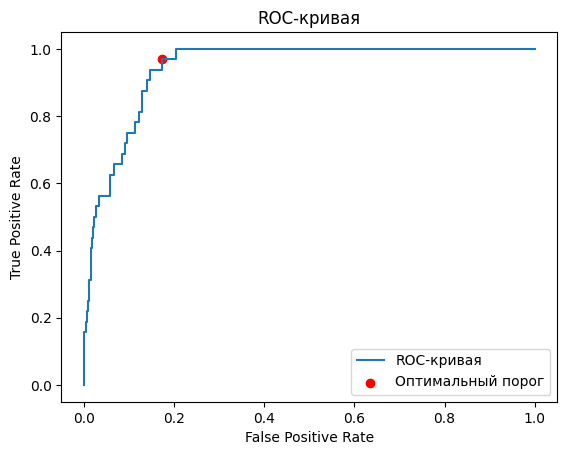

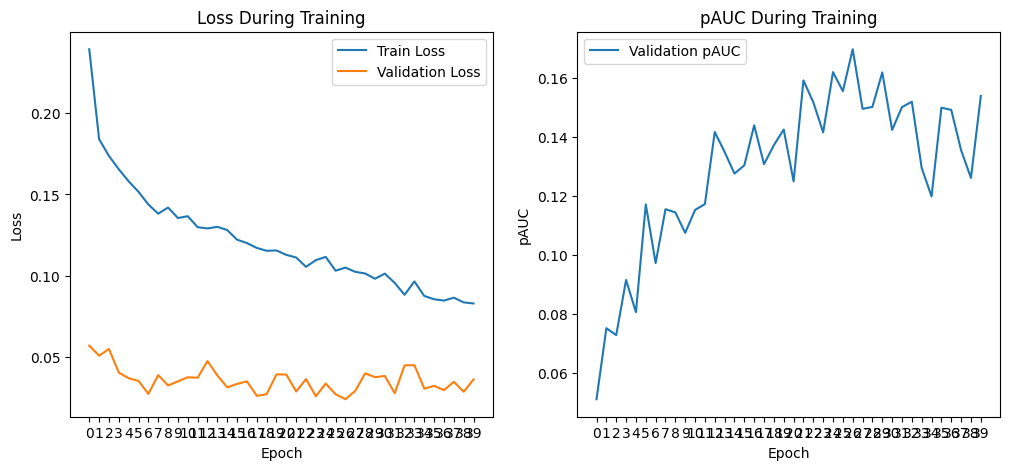

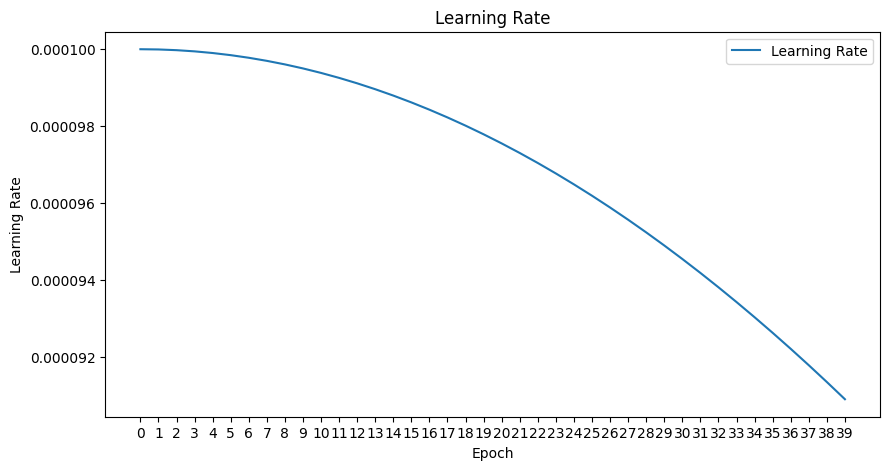

In [ ]:
# Параметры обучения
exp_num = 5
model_name = 'resnet18'
num_epochs = 40
criterion = nn.BCELoss()
history_list = []

print("Training the model on the training data")

model = CustomResNet18Gem(model_name)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

history, optimal_threshold, cm = train_model(model,
                                            train_loader,
                                            val_loader,
                                            criterion,
                                            optimizer,
                                            scheduler,
                                            num_epochs,
                                            device,
                                            exp_num,
                                            model_name,
                                            project_dir,
                                            checkpoint_save=False,
                                            min_tpr=0.8,
                                            )
# Записываем историю обучения
history_list.append(history)

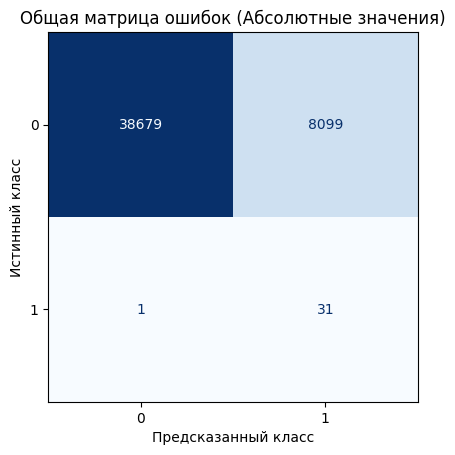

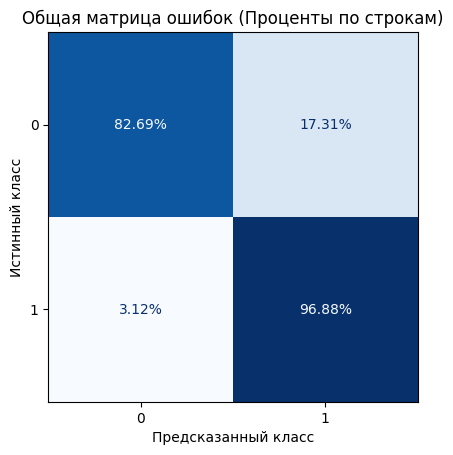

In [ ]:
total_cm_visualize([cm])

**Результат обучения:**  
pAUC: 0.1696  
TPR: 0.9688  
FPR: 0.1731  
Статистика Юдена: 0.7956  